In [1]:
# Upload data.csv to content before running this file.
import matplotlib.pyplot as plt
import random,numpy as np
import seaborn as sb
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, recall_score

In [2]:
# Returns a dictionary of metrics given predicted values, true values, and list of classes to cast to {0,1}. 0 is the negative class, 1 is the positive class.
# So in case the classes present are 1,2, pass as [1,2], not [2,1]. It also prints the 5 metrics, confusion matrix, accuracy, precision, recall, F1 score.
# The formulae and variables are self explanatory.

def metrics(y_pred,y_true,classes):
  df = pd.DataFrame(np.random.randn(2, 2), index=["actual1","actual0"], columns=["pred1","pred0"])
  
  for i in [1,0]:
    for j in [1,0]:
      df["pred"+str(i)]["actual"+str(j)]=((y_pred==classes[i]) & (y_true==classes[j])).sum()
  
  precision = df["pred1"]["actual1"] / df["pred1"].sum()
  recall = df["pred1"]["actual1"] / df.loc["actual1"].sum()
  accuracy = (df["pred1"]["actual1"]+df["pred0"]["actual0"]) / df.sum().sum()
  f1 = 2*precision*recall / (precision+recall)
  
  metrs={}
  metrs['confusion matrix'] = df
  metrs['accuracy'] = accuracy
  metrs['precision'] = precision
  metrs['recall'] = recall
  metrs['f1_score'] = f1
  
  print("Confusion Matrix: ","\n",df)
  print("Accuracy: ",accuracy)
  print("Precision: ",precision)
  print("Recall: ",recall)
  print("F1 score: ",f1)
  return metrs

In [3]:
import io
# wisconsin = pd.read_csv(io.BytesIO(uploaded['data.csv']))
wisconsin=pd.read_csv('data.csv')
print(wisconsin)
wisconsin = wisconsin[list(wisconsin.columns)[1:-1]]

# wisconsin.head(10)
wisconsin.shape


           id diagnosis  ...  fractal_dimension_worst  Unnamed: 32
0      842302         M  ...                  0.11890          NaN
1      842517         M  ...                  0.08902          NaN
2    84300903         M  ...                  0.08758          NaN
3    84348301         M  ...                  0.17300          NaN
4    84358402         M  ...                  0.07678          NaN
..        ...       ...  ...                      ...          ...
564    926424         M  ...                  0.07115          NaN
565    926682         M  ...                  0.06637          NaN
566    926954         M  ...                  0.07820          NaN
567    927241         M  ...                  0.12400          NaN
568     92751         B  ...                  0.07039          NaN

[569 rows x 33 columns]


(569, 31)

In [4]:
# wisconsin.shape   #(569,33)
wisconsin.columns

Index(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


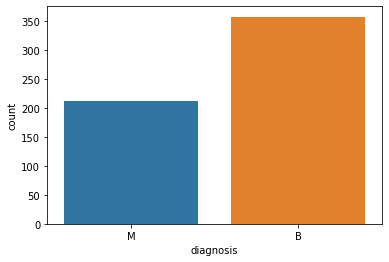

<Figure size 432x288 with 0 Axes>

In [5]:
# Compare the counts of labels to see if there is a case of skewed classes.
sb.countplot(wisconsin['diagnosis'])      # B = 357 , M = 212 
plt.figure().savefig('class count.png')

In [6]:
# Describe the dataset.
wisconsin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

In [7]:
wisconsin.describe()

radius_mean  texture_mean  ...  symmetry_worst  fractal_dimension_worst
count   569.000000    569.000000  ...      569.000000               569.000000
mean     14.127292     19.289649  ...        0.290076                 0.083946
std       3.524049      4.301036  ...        0.061867                 0.018061
min       6.981000      9.710000  ...        0.156500                 0.055040
25%      11.700000     16.170000  ...        0.250400                 0.071460
50%      13.370000     18.840000  ...        0.282200                 0.080040
75%      15.780000     21.800000  ...        0.317900                 0.092080
max      28.110000     39.280000  ...        0.663800                 0.207500

[8 rows x 30 columns]

In [8]:
#Mapping values to numeric data, Malignant represents 1 and Benign represents 0 
wisconsin['diagnosis'] = wisconsin['diagnosis'].map({'M': 1, 'B':0})
y = wisconsin.diagnosis
x = wisconsin.drop(['diagnosis'],axis = 1 )

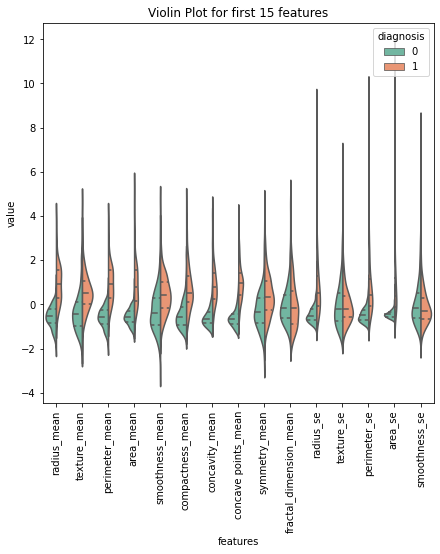

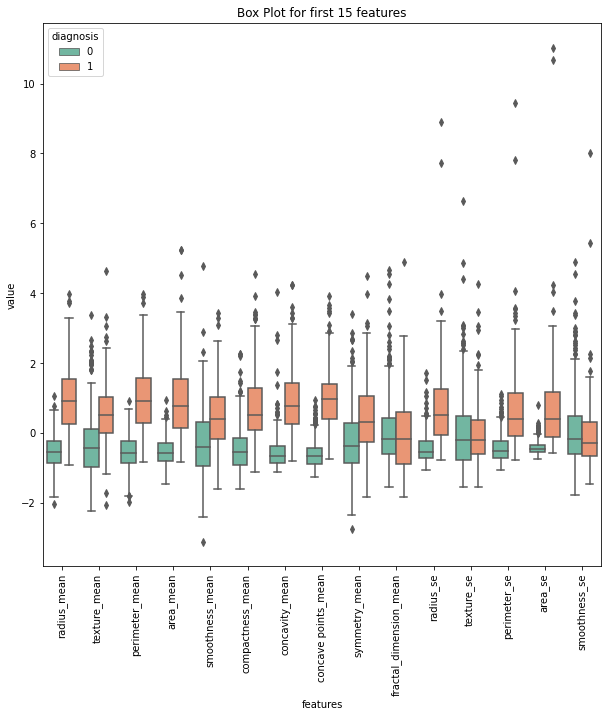

In [9]:
data_new = x
data_standardised = (data_new - data_new.mean()) / (data_new.std())
data_new = pd.concat([y,data_standardised.iloc[:,0:15]],axis=1)
data_new = pd.melt(data_new,id_vars="diagnosis",var_name="features",value_name='value')
#Violin plot to check for correlation with target
plt.figure(figsize=(7,7))
violin1 = sb.violinplot(x="features", y="value", hue="diagnosis", data=data_new,split=True, inner="quart",palette="Set2")
violin1.set_title("Violin Plot for first 15 features")
plt.xticks(rotation=90)
plt.show()
#box plot to check for outliers
plt.figure(figsize=(10,10))
box1 = sb.boxplot(x="features", y="value", hue="diagnosis", data=data_new,palette="Set2")
box1.set_title("Box Plot for first 15 features")
plt.xticks(rotation=90)
plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

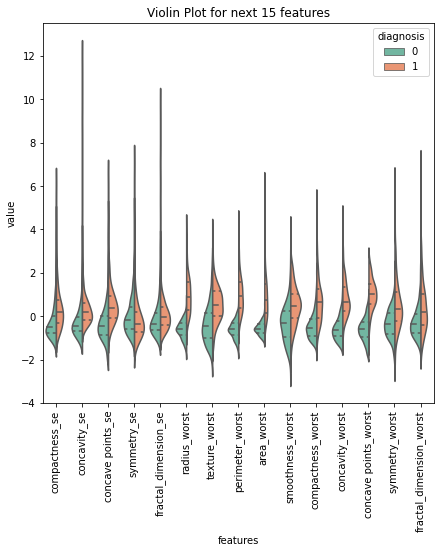

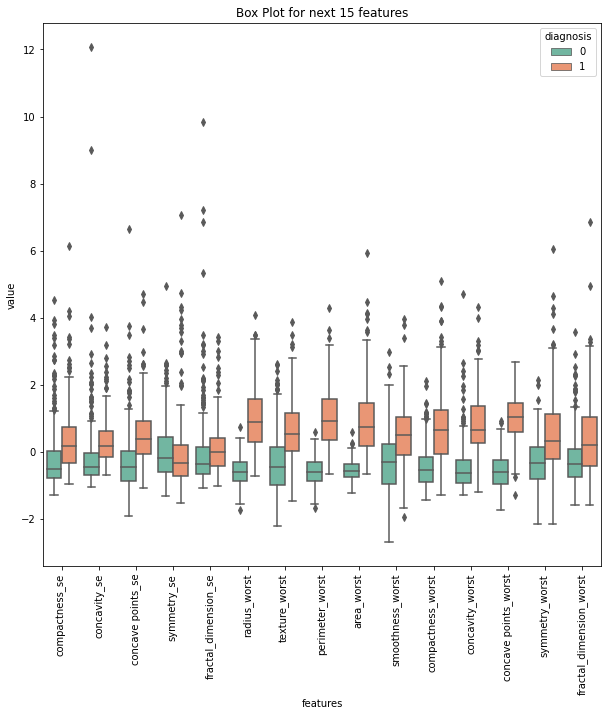

In [10]:
data_new = x
data_standardised = (data_new - data_new.mean()) / (data_new.std())              # standardization
data_new = pd.concat([y,data_standardised.iloc[:,15:30]],axis=1)
data_new = pd.melt(data_new,id_vars="diagnosis",var_name="features",value_name='value')
plt.figure(figsize=(7,7))
violin2 = sb.violinplot(x="features", y="value", hue="diagnosis", data=data_new,split=True, inner="quart",palette="Set2")
violin2.set_title("Violin Plot for next 15 features")
plt.xticks(rotation=90)

plt.figure(figsize=(10,10))
box2 = sb.boxplot(x="features", y="value", hue="diagnosis", data=data_new,palette="Set2")
box2.set_title("Box Plot for next 15 features")
plt.xticks(rotation=90)

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition

X_scaled = StandardScaler().fit_transform(data_standardised)

In [12]:
pca_initial = decomposition.PCA()
pcafit = pca_initial.fit_transform(X_scaled,y)
var_explained = pca_initial.explained_variance_ratio_ 
print(sum(var_explained[0:2]))
print(sum(var_explained[0:6]))
print(sum(var_explained[0:7]))
print(sum(var_explained[0:10]))
print(sum(var_explained[0:15]))
print(sum(var_explained[0:20]))
print(sum(var_explained[0:30]))
##indeed,the first 10 PCs explain 95% of the variance

0.6324320765155941
0.8875879635669056
0.9100953006967307
0.9515688143366666
0.9864881227145468
0.9955720432628137
1.0


Projecting 30-dimensional data to 2D


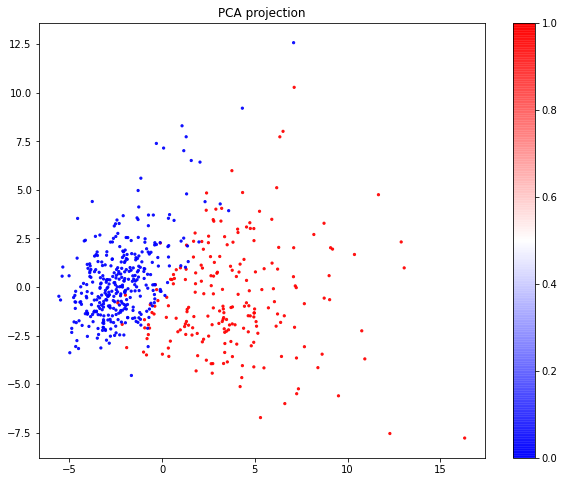

In [13]:
# fit scaler on training data
normal = StandardScaler().fit(x)
# transform training data
hello = normal.transform(x)
# transform testing dataabs
pca = decomposition.PCA(n_components=10)
X_pca_scaled = pca.fit_transform(hello)
print('Projecting %d-dimensional data to 2D' % X_scaled.shape[1])
plt.figure(figsize=(10,8))
plt.scatter(X_pca_scaled[:, 0], X_pca_scaled[:, 1], c=wisconsin['diagnosis'], alpha=0.9, s=20, cmap='bwr',marker='.');
plt.colorbar()
plt.title('PCA projection')
plt.style.use('seaborn-muted');

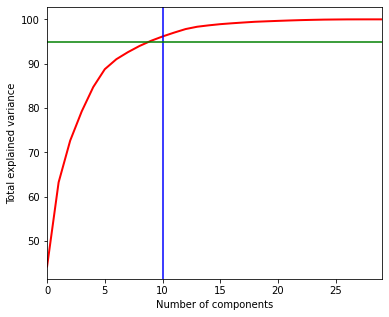

In [14]:
pca = decomposition.PCA().fit(X_scaled)
plt.figure(figsize=(6,5))
plt.plot(100*np.cumsum(pca.explained_variance_ratio_), color='r', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 29)
plt.axvline(10, c='b')
plt.axhline(95.0, c='g')
plt.show();

In [15]:
# Do feature scaling
from sklearn.preprocessing import StandardScaler


X_train_pca, X_test_pca, y_train, y_test = train_test_split(x, y, test_size=0.20, 
                                                            shuffle=True, random_state=0)
# fit scaler on training data
norm = StandardScaler().fit(X_train_pca)
# transform training data
X_train_pca_norm = norm.transform(X_train_pca)
# transform testing dataabs
X_test_pca_norm = norm.transform(X_test_pca)

# sc = StandardScaler()
# X_scaled = sc.fit_transform(x)

# Apply PCA
from sklearn.decomposition import PCA
dimension = 10
pca = PCA(n_components=dimension)
# X_pca = pca.fit_transform(X_scaled)
fitter = pca.fit(X_train_pca_norm)
X_pca = fitter.transform(X_train_pca_norm)
X_test_pca_norm = fitter.transform(X_test_pca_norm)
# Get the transformed dataset
X_pca1 = pd.DataFrame(X_pca)
# print(X_pca.head())
print("\nSize: ")
print(X_pca1.shape)

fig = plt.figure(figsize=(7, 5))
heat = sb.heatmap(X_pca1.corr(),cmap='magma')
heat.set_title('Correlation in PCA Components');


Size: 
(455, 10)


Train accuracy: 0.99
Test accuracy: 0.95
Test Recall: 0.94

Test confusion_matrix


Text(33.0, 0.5, 'True')

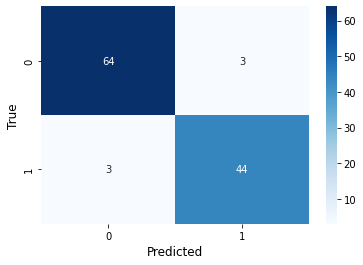

In [16]:
# Make train and test sets
from sklearn.model_selection import train_test_split


# X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.20, 
#                                                             shuffle=True, random_state=0)

# Initialize the logistic regression model
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=2500)

# Train the model
clf.fit(X_pca, y_train)

# Make predictions
y_pred = clf.predict(X_test_pca_norm) # Predictions
y_true = y_test # True values

# Measure accuracy
from sklearn.metrics import accuracy_score
import numpy as np
print("Train accuracy:", np.round(accuracy_score(y_train, 
                                                 clf.predict(X_pca)), 2))
print("Test accuracy:", np.round(accuracy_score(y_true, y_pred), 2))

# Make the confusion matrix
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print("Test Recall:", np.round(cf_matrix[1][1]/(cf_matrix[1][1]+cf_matrix[1][0]),2))
print("\nTest confusion_matrix")
sb.heatmap(cf_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)

In [17]:
data_pure = pd.read_csv("data.csv")
data_pure = data_pure.drop('Unnamed: 32', 1)
data_pure = data_pure.drop('id', 1)

X = data_pure.drop('diagnosis',1)
data_pure['diagnosis']  = data_pure['diagnosis'].map({'M': 1, 'B':0})
y = pd.Series(data_pure.diagnosis)

Train accuracy: 0.99
Test accuracy: 0.96
Test Recall: 0.96

Test confusion_matrix


Text(33.0, 0.5, 'True')

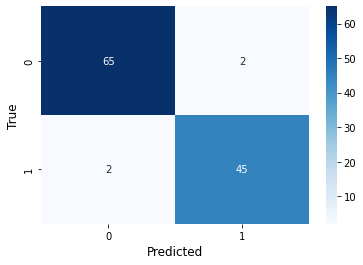

In [18]:
# Make train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                    shuffle=True, random_state=0)

norm = StandardScaler().fit(X_train)
# transform training data
X_train_norm = norm.transform(X_train)
# transform testing dataabs
X_test_norm = norm.transform(X_test)

# Initialize the logistic regression model
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=2500)

# Train the model
clf.fit(X_train_norm, y_train)

# Make predictions
y_pred = clf.predict(X_test_norm) # Predictions
y_true = y_test # True values

# Measure accuracy
from sklearn.metrics import accuracy_score
import numpy as np
print("Train accuracy:", np.round(accuracy_score(y_train, 
                                                 clf.predict(X_train_norm)), 2))
print("Test accuracy:", np.round(accuracy_score(y_true, y_pred), 2))

# Make the confusion matrix
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_true, y_pred)

print("Test Recall:", np.round(cf_matrix[1][1]/(cf_matrix[1][1]+cf_matrix[1][0]),2))
print("\nTest confusion_matrix")
sb.heatmap(cf_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)

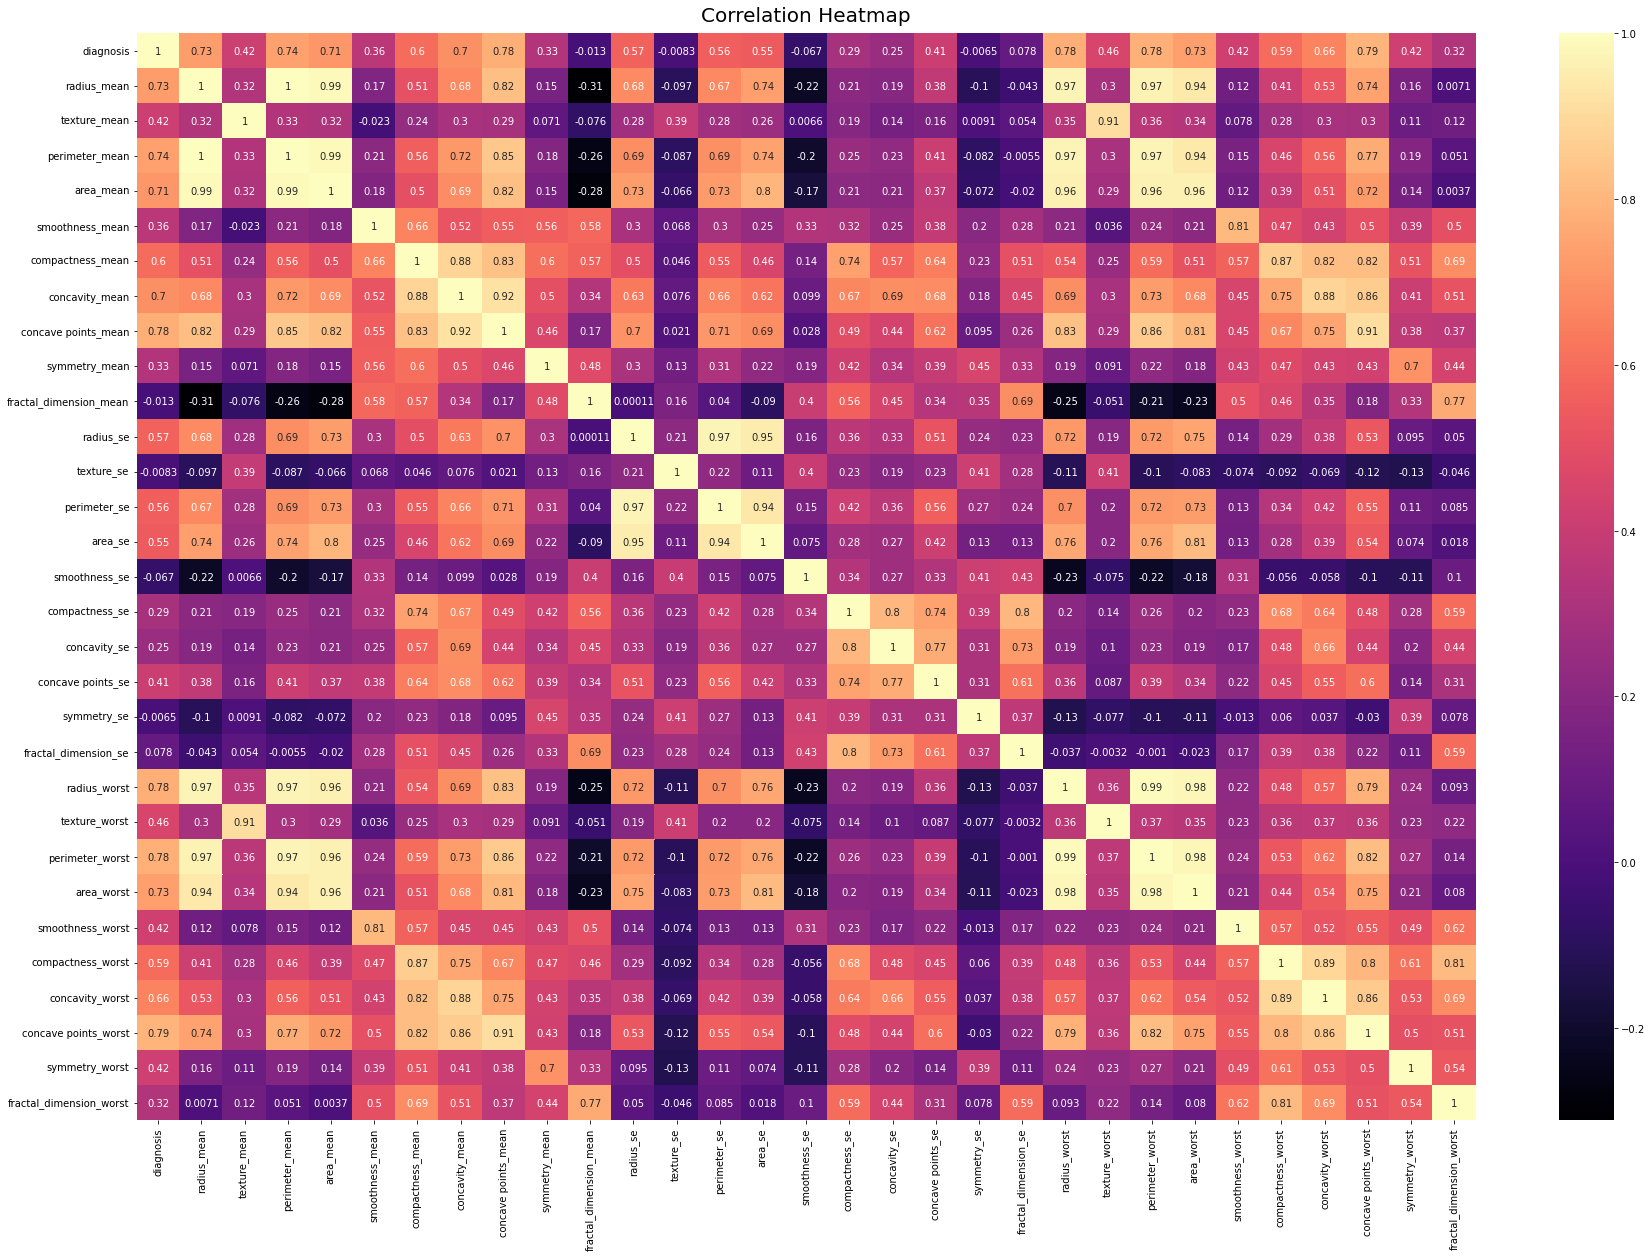

In [19]:
# HEATMAP FOR VISUALISING CORRELATION BETWEEN FEATURES
"""
'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired',
 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 
 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r',
  'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 
  'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'magma',
  'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray',
   'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r',
    'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 

"""
fig = plt.figure(figsize=(30, 20))
heatmap = sb.heatmap(wisconsin.corr(),  cmap='magma',annot=True)

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':20}, pad=12)

fig.savefig('Correlation.png')

In [20]:
wisconsin

diagnosis  radius_mean  ...  symmetry_worst  fractal_dimension_worst
0            1        17.99  ...          0.4601                  0.11890
1            1        20.57  ...          0.2750                  0.08902
2            1        19.69  ...          0.3613                  0.08758
3            1        11.42  ...          0.6638                  0.17300
4            1        20.29  ...          0.2364                  0.07678
..         ...          ...  ...             ...                      ...
564          1        21.56  ...          0.2060                  0.07115
565          1        20.13  ...          0.2572                  0.06637
566          1        16.60  ...          0.2218                  0.07820
567          1        20.60  ...          0.4087                  0.12400
568          0         7.76  ...          0.2871                  0.07039

[569 rows x 31 columns]

In [21]:
# Feature extraction:  correlation with target label if greater than 0.45 than feature should be considered

copy = wisconsin.copy()
# copy['encoded_diagnosis'] = 1*(copy['diagnosis']=='M')
# print(copy['encoded_diagnosis'][10:], copy['diagnosis'][10:])


correlation_wrt_diagnosis = abs(copy.corr()['diagnosis'])

highly_correlated_feature = correlation_wrt_diagnosis[correlation_wrt_diagnosis > 0.45]

fin= highly_correlated_feature.drop(['texture_worst','area_mean','perimeter_mean','area_worst','perimeter_worst'])

print(highly_correlated_feature,'nl')

fin
"""
{'alpha': 0.0001, 'eta0': 0.3, 'learning_rate': 'constant', 'loss': 'log', 'random_state': 0}
Confusion Matrix:  
          pred1  pred0
actual1   45.0    2.0
actual0    5.0   62.0
Accuracy:  0.9385964912280702
Precision:  0.9
Recall:  0.9574468085106383
F1 score:  0.9278350515463918
"""

diagnosis               1.000000
radius_mean             0.730029
perimeter_mean          0.742636
area_mean               0.708984
compactness_mean        0.596534
concavity_mean          0.696360
concave points_mean     0.776614
radius_se               0.567134
perimeter_se            0.556141
area_se                 0.548236
radius_worst            0.776454
texture_worst           0.456903
perimeter_worst         0.782914
area_worst              0.733825
compactness_worst       0.590998
concavity_worst         0.659610
concave points_worst    0.793566
Name: diagnosis, dtype: float64 nl


"\n{'alpha': 0.0001, 'eta0': 0.3, 'learning_rate': 'constant', 'loss': 'log', 'random_state': 0}\nConfusion Matrix:  \n          pred1  pred0\nactual1   45.0    2.0\nactual0    5.0   62.0\nAccuracy:  0.9385964912280702\nPrecision:  0.9\nRecall:  0.9574468085106383\nF1 score:  0.9278350515463918\n"

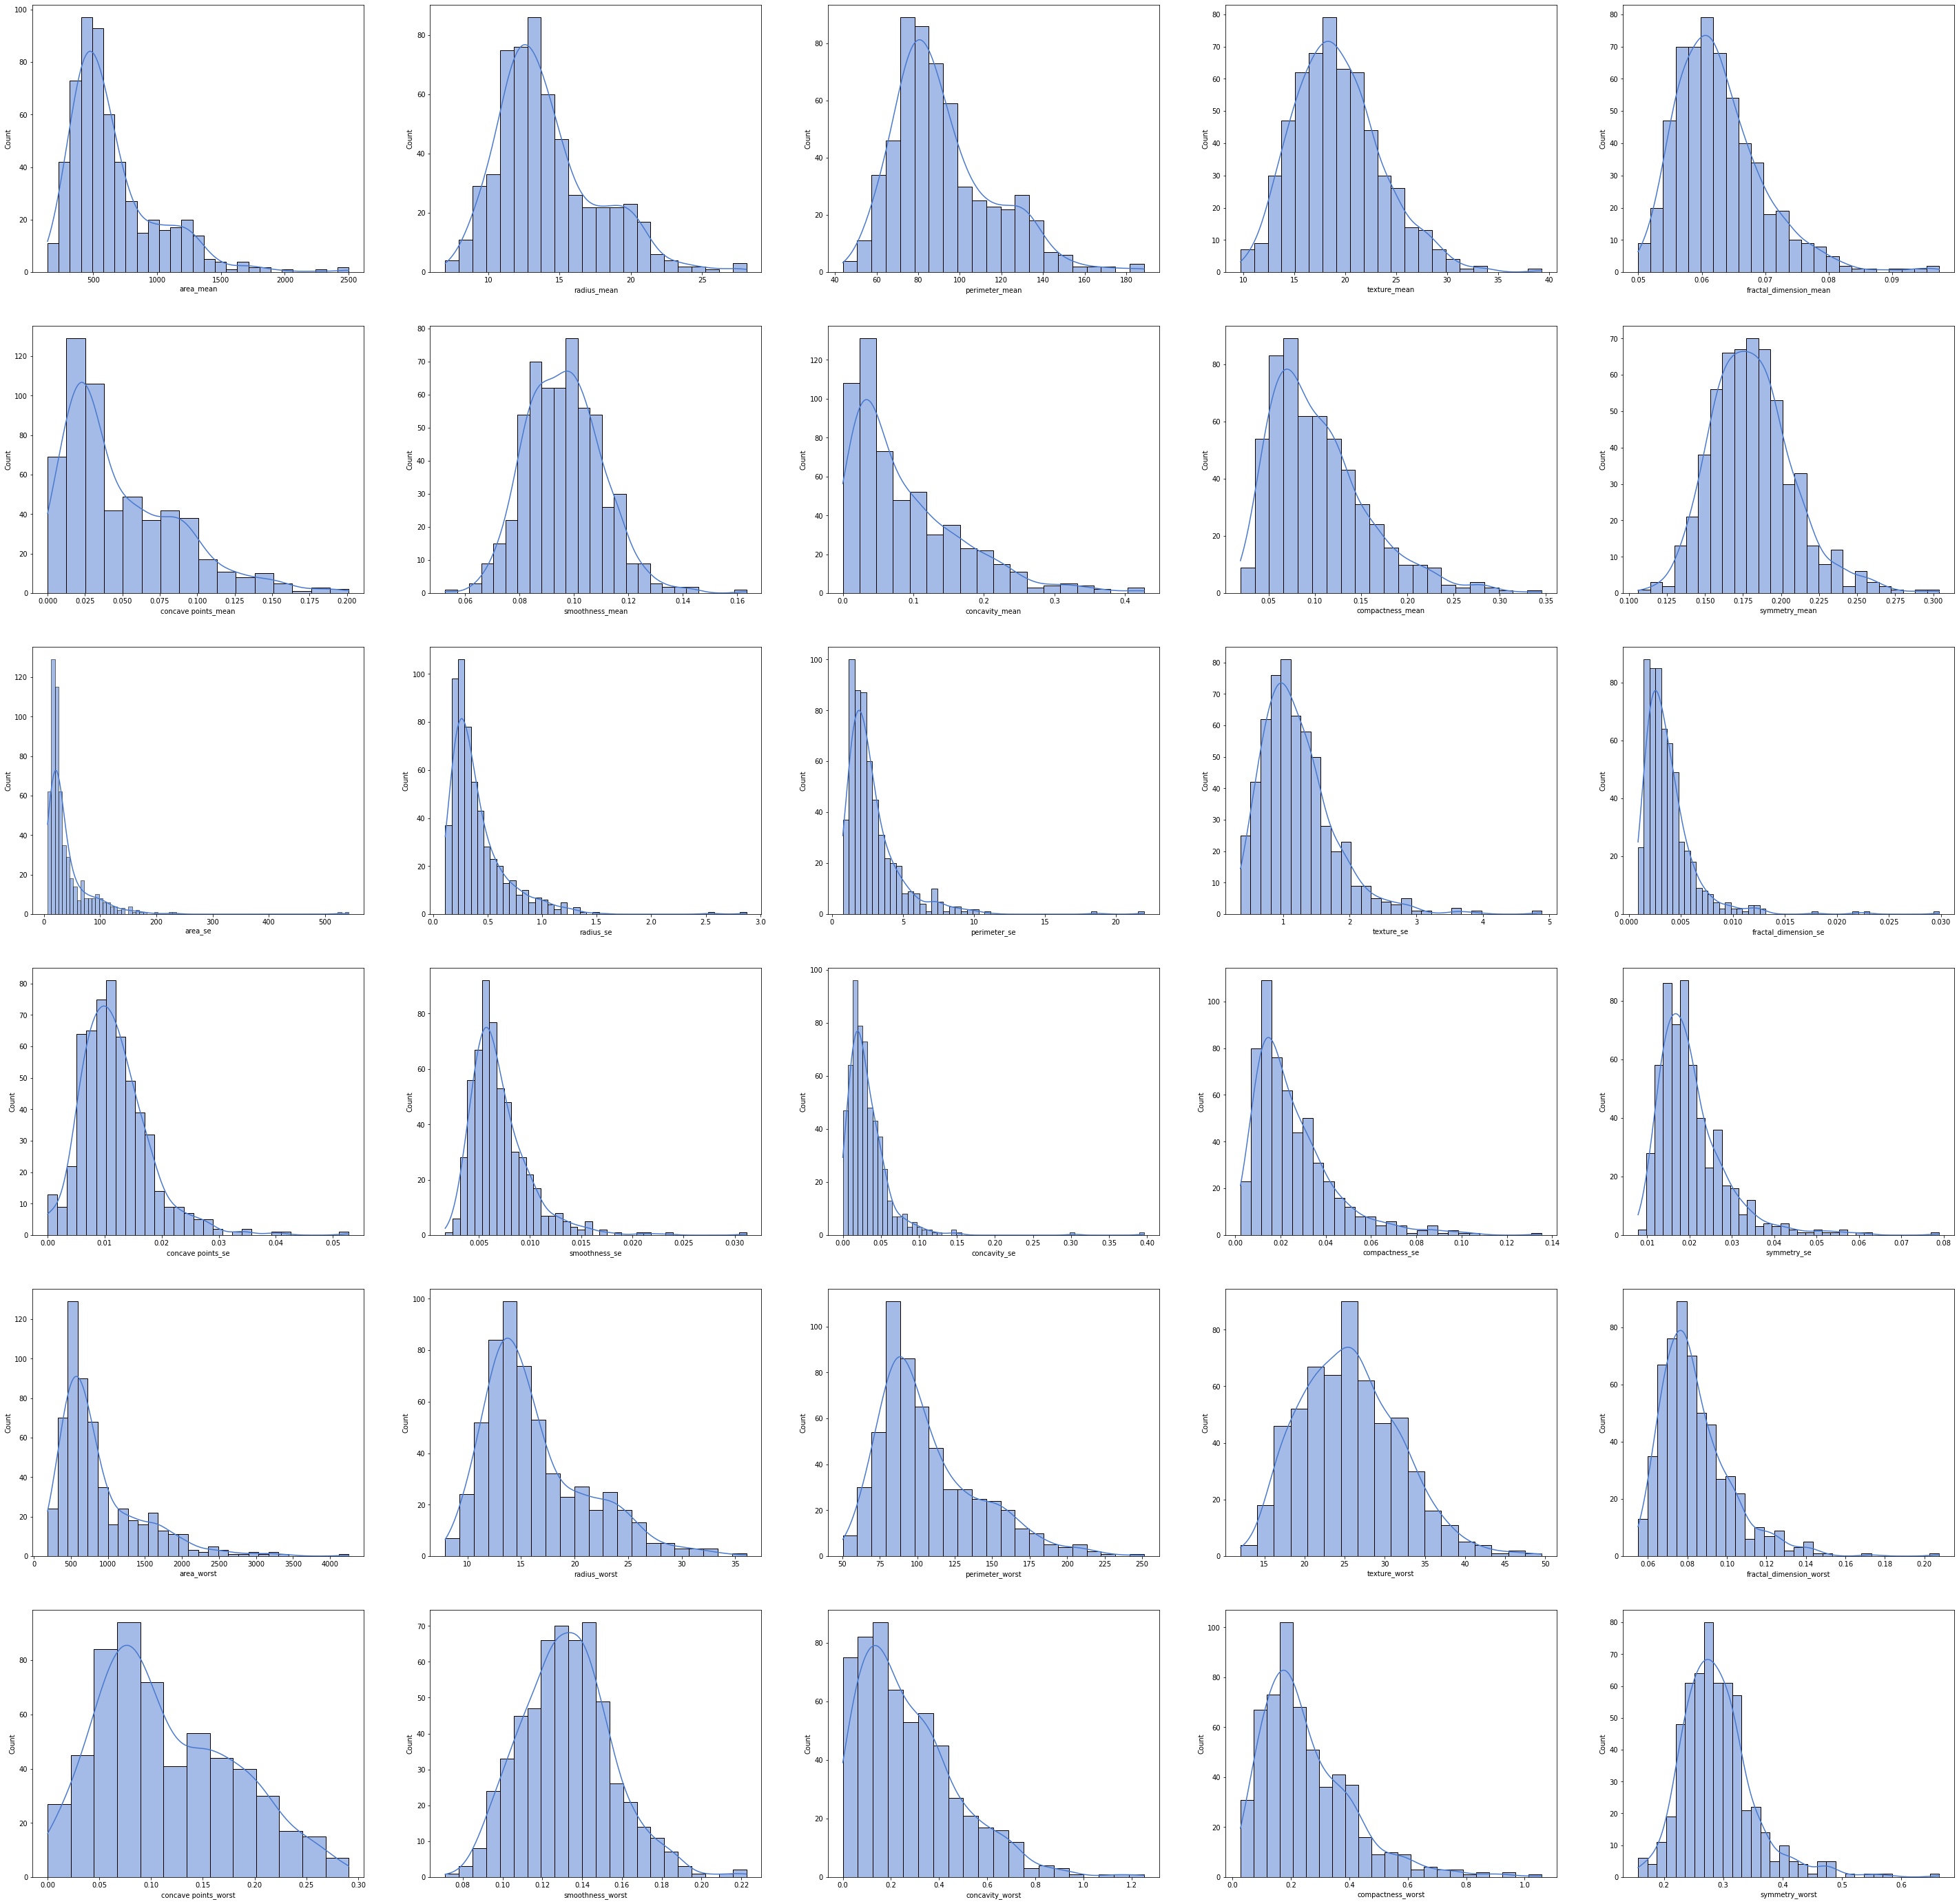

In [22]:
# DISTRIBUTION OF DATA IN FEATURES
fig, axes = plt.subplots(6,5,figsize=(50,50))

sb.histplot(wisconsin['area_mean'],ax = axes[0,0],kde=True)
sb.histplot(wisconsin['radius_mean'],ax = axes[0,1],kde=True)
sb.histplot(wisconsin['perimeter_mean'],ax = axes[0,2],kde=True)
sb.histplot(wisconsin['texture_mean'],ax = axes[0,3],kde=True)
sb.histplot(wisconsin['fractal_dimension_mean'],ax = axes[0,4],kde=True)

sb.histplot(wisconsin['concave points_mean'],ax = axes[1,0],kde=True)
sb.histplot(wisconsin['smoothness_mean'],ax = axes[1,1],kde=True)
sb.histplot(wisconsin['concavity_mean'],ax = axes[1,2],kde=True)
sb.histplot(wisconsin['compactness_mean'],ax = axes[1,3],kde=True)
sb.histplot(wisconsin['symmetry_mean'],ax = axes[1,4],kde=True)

sb.histplot(wisconsin['area_se'],ax = axes[2,0],kde=True)
sb.histplot(wisconsin['radius_se'],ax = axes[2,1],kde=True)
sb.histplot(wisconsin['perimeter_se'],ax = axes[2,2],kde=True)
sb.histplot(wisconsin['texture_se'],ax = axes[2,3],kde=True)
sb.histplot(wisconsin['fractal_dimension_se'],ax = axes[2,4],kde=True)

sb.histplot(wisconsin['concave points_se'],ax = axes[3,0],kde=True)
sb.histplot(wisconsin['smoothness_se'],ax = axes[3,1],kde=True)
sb.histplot(wisconsin['concavity_se'],ax = axes[3,2],kde=True)
sb.histplot(wisconsin['compactness_se'],ax = axes[3,3],kde=True)
sb.histplot(wisconsin['symmetry_se'],ax = axes[3,4],kde=True)

sb.histplot(wisconsin['area_worst'],ax = axes[4,0],kde=True)
sb.histplot(wisconsin['radius_worst'],ax = axes[4,1],kde=True)
sb.histplot(wisconsin['perimeter_worst'],ax = axes[4,2],kde=True)
sb.histplot(wisconsin['texture_worst'],ax = axes[4,3],kde=True)
sb.histplot(wisconsin['fractal_dimension_worst'],ax = axes[4,4],kde=True)

sb.histplot(wisconsin['concave points_worst'],ax = axes[5,0],kde=True)
sb.histplot(wisconsin['smoothness_worst'],ax = axes[5,1],kde=True)
sb.histplot(wisconsin['concavity_worst'],ax = axes[5,2],kde=True)
sb.histplot(wisconsin['compactness_worst'],ax = axes[5,3],kde=True)
sb.histplot(wisconsin['symmetry_worst'],ax = axes[5,4],kde=True)

fig.savefig('feature distribution.png')

** linearly separable columns- 'concavity_mean', 'compactness_mean', 'concave points_mean',texture_mean, 'radius_mean', 'perimeter_mean', 'area_mean' **

**less useful columns - 'smoothness' , 'fractal_dimension', 'symmetry_mean'** 

From above cell, we found there are no null values in any columns in our dataset


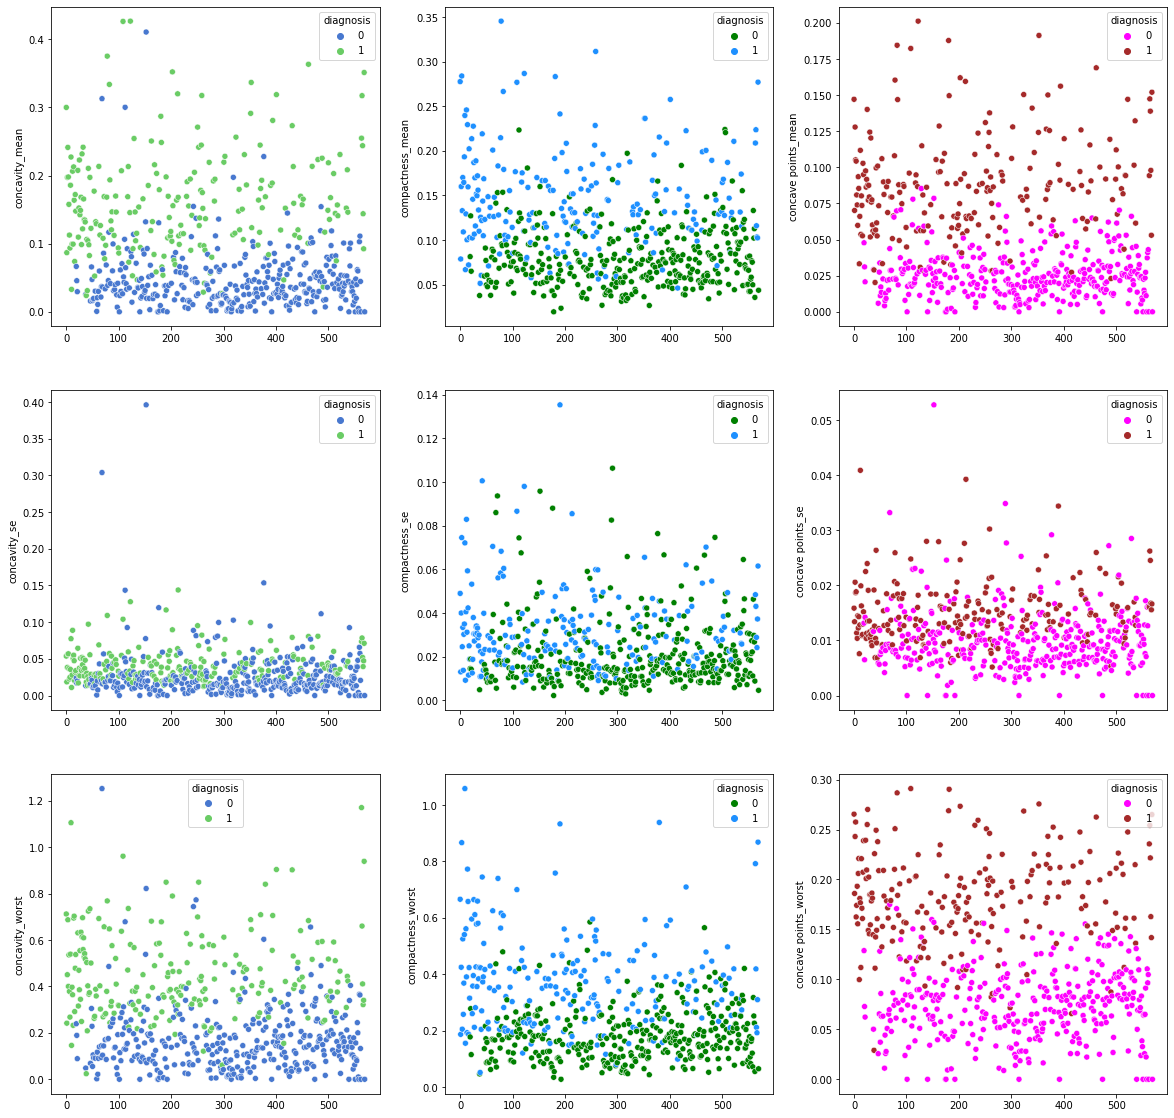

In [23]:
fig, axs = plt.subplots(nrows=3,ncols=3)

x = np.linspace(0,569,num=569)

fig.set_figheight(20)
fig.set_figwidth(20)

sb.scatterplot(x=x, y='concavity_mean', hue='diagnosis', data=wisconsin,ax=axs[0][0])
sb.scatterplot(x=x, y='compactness_mean', hue='diagnosis', data=wisconsin,ax=axs[0][1],palette=['green','dodgerBlue'])
sb.scatterplot(x=x, y='concave points_mean', hue='diagnosis', data=wisconsin,ax=axs[0][2],palette=['Magenta','brown'])

sb.scatterplot(x=x, y='concavity_se', hue='diagnosis', data=wisconsin,ax=axs[1][0])
sb.scatterplot(x=x, y='compactness_se', hue='diagnosis', data=wisconsin,ax=axs[1][1],palette=['green','dodgerBlue'])
sb.scatterplot(x=x, y='concave points_se', hue='diagnosis', data=wisconsin,ax=axs[1][2],palette=['Magenta','brown'])

sb.scatterplot(x=x, y='concavity_worst', hue='diagnosis', data=wisconsin,ax=axs[2][0])
sb.scatterplot(x=x, y='compactness_worst', hue='diagnosis', data=wisconsin,ax=axs[2][1],palette=['green','dodgerBlue'])
sb.scatterplot(x=x, y='concave points_worst', hue='diagnosis', data=wisconsin,ax=axs[2][2],palette=['Magenta','brown'])


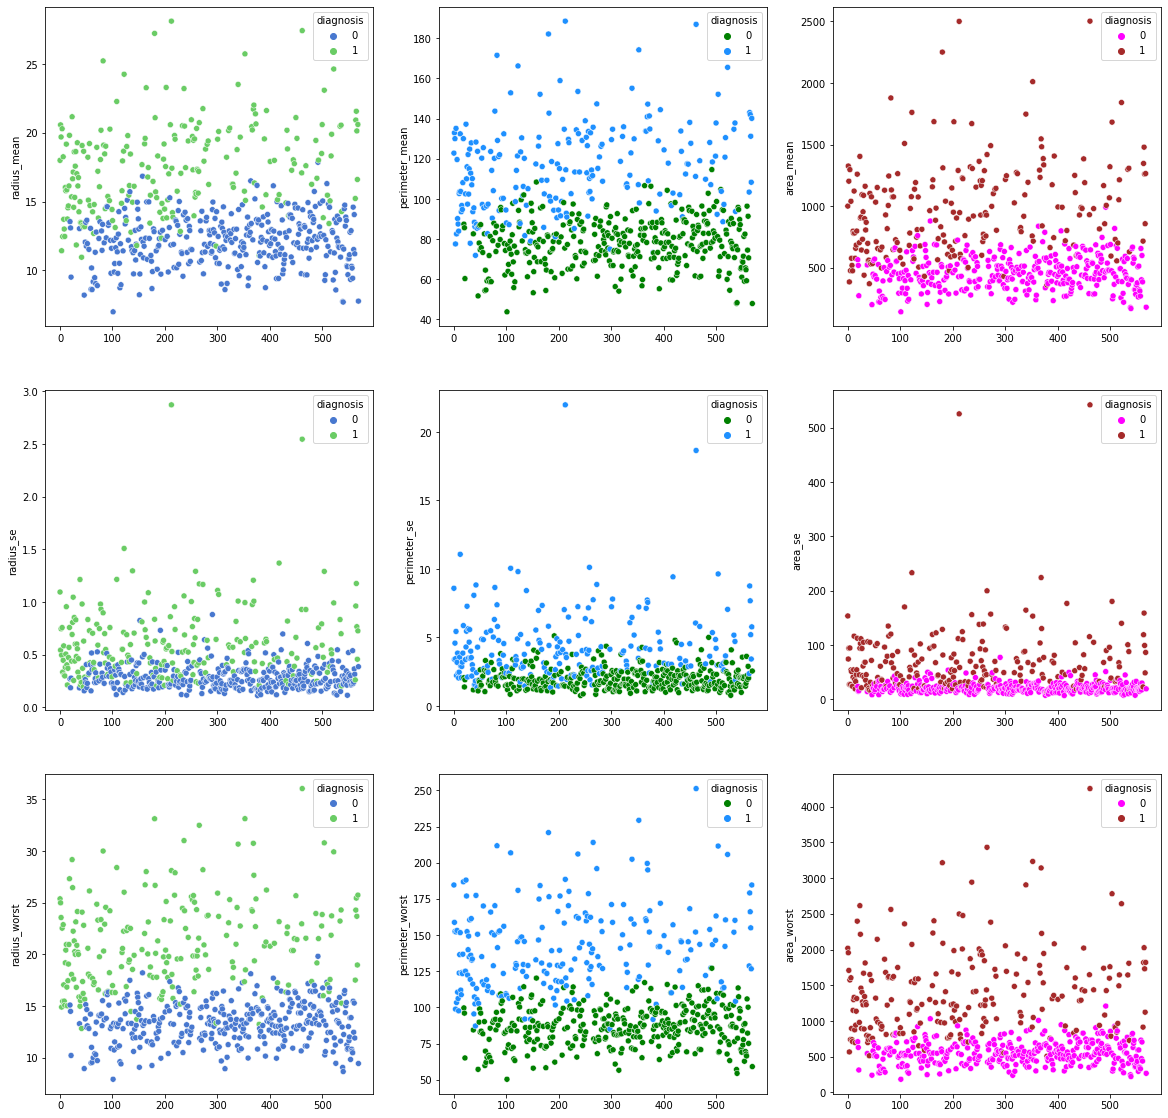

In [24]:

x = np.linspace(0,569,num=569)

fig, axs = plt.subplots(nrows=3,ncols=3)

fig.set_figheight(20)
fig.set_figwidth(20)

sb.scatterplot(x=x, y='radius_mean', hue='diagnosis', data=wisconsin,ax=axs[0][0])
sb.scatterplot(x=x, y='perimeter_mean', hue='diagnosis', data=wisconsin,ax=axs[0][1],palette=['green','dodgerBlue'])
sb.scatterplot(x=x, y='area_mean', hue='diagnosis', data=wisconsin,ax=axs[0][2],palette=['Magenta','brown'])

sb.scatterplot(x=x, y='radius_se', hue='diagnosis', data=wisconsin,ax=axs[1][0])
sb.scatterplot(x=x, y='perimeter_se', hue='diagnosis', data=wisconsin,ax=axs[1][1],palette=['green','dodgerBlue'])
sb.scatterplot(x=x, y='area_se', hue='diagnosis', data=wisconsin,ax=axs[1][2],palette=['Magenta','brown'])

sb.scatterplot(x=x, y='radius_worst', hue='diagnosis', data=wisconsin,ax=axs[2][0])
sb.scatterplot(x=x, y='perimeter_worst', hue='diagnosis', data=wisconsin,ax=axs[2][1],palette=['green','dodgerBlue'])
sb.scatterplot(x=x, y='area_worst', hue='diagnosis', data=wisconsin,ax=axs[2][2],palette=['Magenta','brown'])

fig.savefig('Physical scatterplot.png')

from the above cell code we get to know that the malignant nuclei is physically larger than tha benign cancer nuclei as it has more mean radius, perimeter and area. 


light textured Malignant nuclei:  344
dark textured Malignant nuclei:  225

light textured Benign nuclei:  0
dark textured Benign nuclei:  0


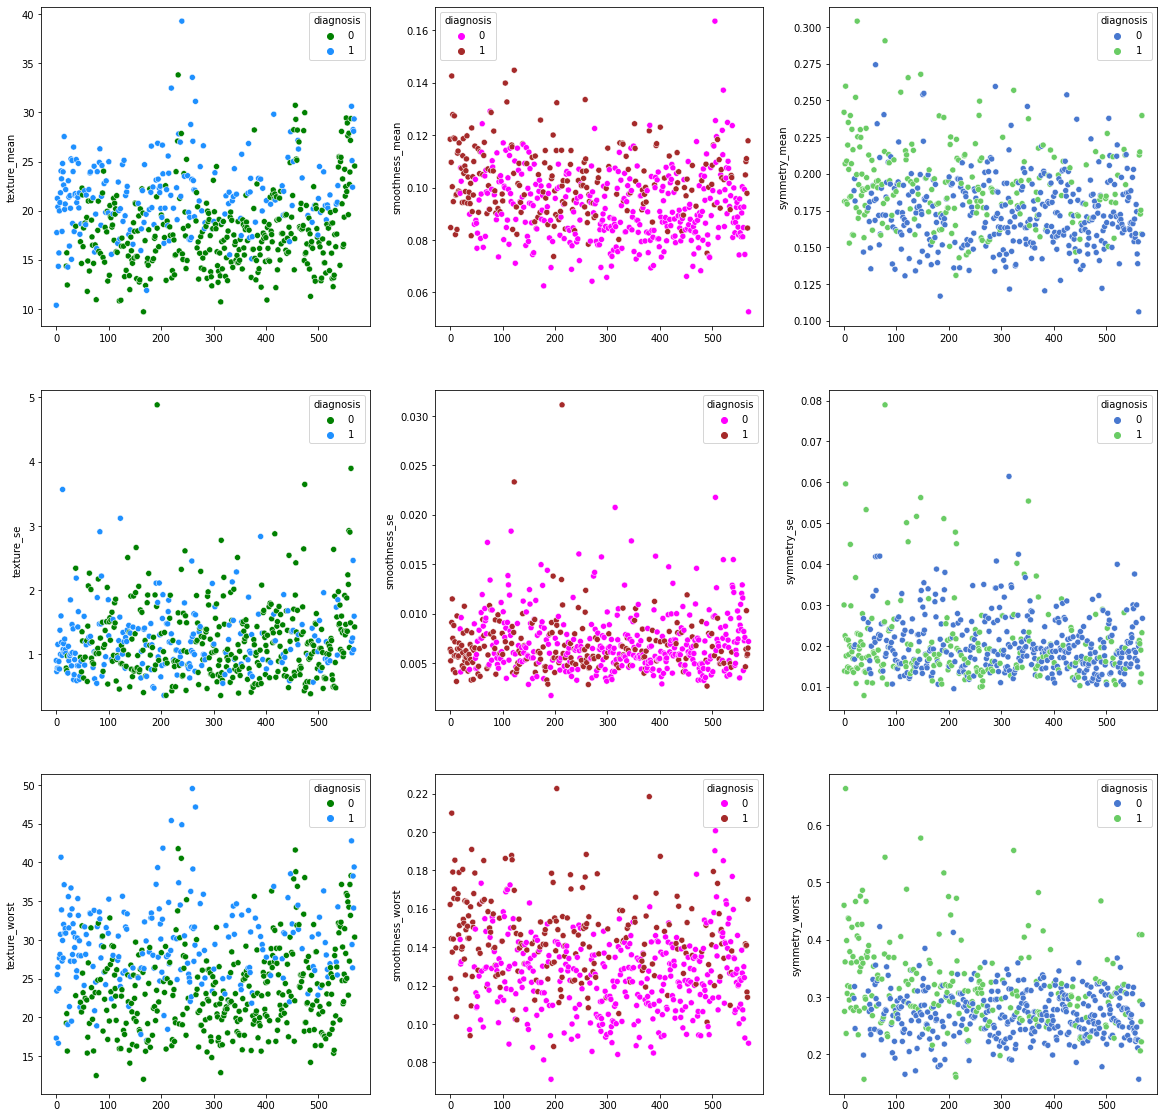

In [25]:
fig, axs = plt.subplots(nrows=3,ncols=3)

# Changing Seaborn Plot size
fig.set_figheight(20)
fig.set_figwidth(20)

sb.scatterplot(data=wisconsin, x=x, y="texture_mean", hue="diagnosis",ax=axs[0][0],palette=['green','dodgerBlue'])
sb.scatterplot(x=x, y='smoothness_mean', hue='diagnosis', data=wisconsin,ax=axs[0][1],palette=['Magenta','brown'])
sb.scatterplot(x=x, y='symmetry_mean', hue='diagnosis', data=wisconsin,ax=axs[0][2])

sb.scatterplot(data=wisconsin, x=x, y="texture_se", hue="diagnosis",ax=axs[1][0],palette=['green','dodgerBlue'])
sb.scatterplot(x=x, y='smoothness_se', hue='diagnosis', data=wisconsin,ax=axs[1][1],palette=['Magenta','brown'])
sb.scatterplot(x=x, y='symmetry_se', hue='diagnosis', data=wisconsin,ax=axs[1][2])


sb.scatterplot(data=wisconsin, x=x, y="texture_worst", hue="diagnosis",ax=axs[2][0],palette=['green','dodgerBlue'])
sb.scatterplot(x=x, y='smoothness_worst', hue='diagnosis', data=wisconsin,ax=axs[2][1],palette=['Magenta','brown'])
sb.scatterplot(x=x, y='symmetry_worst', hue='diagnosis', data=wisconsin,ax=axs[2][2])


light,dark = 0,0
light_benign, dark_benign= 0,0
for i in range(0,569):
  if wisconsin["texture_mean"][i]<20:
    if wisconsin["diagnosis"][i]=='B':
      light_benign+=1
    else:
      light+=1
  else:
    if wisconsin["diagnosis"][i]=='B':
      dark_benign+=1
    else:
      dark+=1

print("light textured Malignant nuclei: ",light)
print("dark textured Malignant nuclei: ",dark)

print("\nlight textured Benign nuclei: ",light_benign)
print("dark textured Benign nuclei: ",dark_benign)


from the above plot and code we found that half of the malignant nuclei are darker in appearance and 2/3rd of the benign nuclei is lighter in appearance

Since form plt we can see that data is linearly separable, decision tree can be opted to give high accuracy

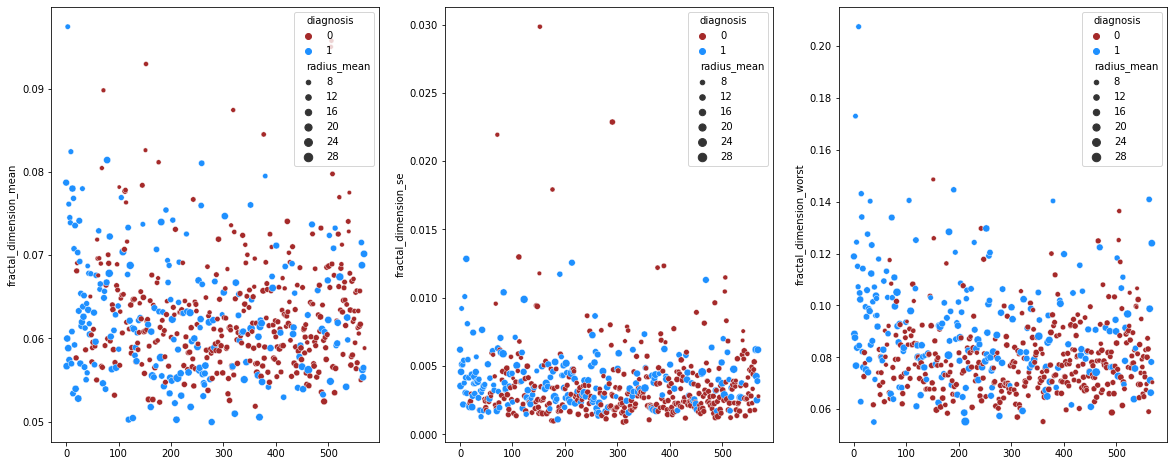

In [26]:
fig, axs = plt.subplots(ncols=3)

fig.set_figheight(8)
fig.set_figwidth(20)

sb.scatterplot(data=wisconsin, x=x, y="fractal_dimension_mean", hue="diagnosis", size="radius_mean",ax= axs[0] ,palette=['brown','dodgerBlue'])
sb.scatterplot(data=wisconsin, x=x, y="fractal_dimension_se", hue="diagnosis", size="radius_mean",ax= axs[1] ,palette=['brown','dodgerBlue'])
sb.scatterplot(data=wisconsin, x=x, y="fractal_dimension_worst", hue="diagnosis", size="radius_mean",ax= axs[2] ,palette=['brown','dodgerBlue'])

fig.savefig('Fractal dim.png')

Previous studies show that fractal dimension increases with Malignancy but other studies also state that the opposite trend. We can see from this plot that it is indeed true that both the type of nuclei have similar ranges of fractal dimension. There is no clear boundary/threshold in fractal dimension that separates the 2 nuclei from each other. 

In [27]:
# Make X,y for classification
X = wisconsin.drop(['diagnosis'],axis=1)
y = wisconsin["diagnosis"]

# X.columns

X=X.to_numpy()
y=y.to_numpy()

In [28]:
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,

In [29]:
# Train-test split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)
# print(X_train)


(455, 30) (114, 30) (455,) (114,)


In [30]:
#   accuracy as metric

"""
    col_list :   <feature name> : [<column index in data>, <range start>, <range end> ,<step-size>]

'radius_mean 1', 'texture_mean2', 'perimeter_mean3', 'area_mean4',
       'smoothness_mea5', 'compactness_mean6', 'concavity_mean7',
       'concave points_mean8', 'symmetry_mean9', 'fractal_dimension_mean10',
       'radius_se11', 'texture_se12', 'perimeter_se13', 'area_se14', 'smoothness_se15',
       'compactness_se16', 'concavity_se17', 'concave points_se18', 'symmetry_se19',
       'fractal_dimension_se20', 'radius_worst21', 'texture_worst22',
       'perimeter_worst23', 'area_worst24', 'smoothness_worst25',

       'compactness_worst26', 'concavity_worst27', 'concave points_worst28',
       'symmetry_worst29', 'fractal_dimension_worst30'],


       radius_mean             0.730029
compactness_mean        0.596534
concavity_mean          0.696360
concave points_mean     0.776614
radius_se               0.567134
perimeter_se            0.556141
area_se                 0.548236
radius_worst            0.776454
compactness_worst       0.590998
concavity_worst         0.659610
concave points_worst    0.793566
"""

col_list = {'concavity_mean':[6,0.05,0.17,0.005], 'compactness_mean':[5,0.07,0.15,0.005],  'concave points_mean':[7,0.025,0.075,0.001], 
            'radius_mean':[0,12,17,0.01],         'perimeter_mean':[2,80,110,0.01],        'area_mean':[3,500,750,1], 
            'concavity_worst':[26,0.2,0.4,0.02],  'compactness_worst':[25,0.18,0.4,0.02],  'concave point_worst':[27,0.08,0.16,0.005],
            'radius_se':[10,0.2,0.6,0.02],        'perimeter_se':[12,2,5,0.1],             'area_se':[13,15,60,2],
            'radius_worst':[20,15,18,0.5],        'perimeter_worst':[22,80,125,1],         'area_worst':[23,600,1000,50]
}

result = {}

for col in col_list:  
  j = col_list[col][0]
  beg = col_list[col][1]
  end = col_list[col][2]
  step = col_list[col][3]
  
  result[col] = [0,0]

  val = beg
  while val <= end+step:
    y_pred = []
    for i in range(len(X_train)): 
      if X_train[i][j] > val:
        y_pred.append(1)
      else:
        y_pred.append(0)
    # print(y_train)
    y_pred = np.array(y_pred).reshape(y_train.shape)
    # print(y_pred,'\n',y_train)
    val_accuracy = (y_pred == y_train).sum()/y_train.shape[0]
    # f1 = f1_score(y_train,y_pred)

    if result[col][0] < val_accuracy:
    # if result[col][0] < f1:
      ls = []
      ls.append(val_accuracy)
      # ls.append(f1)
      ls.append(val)
      
      result[col] = ls
    # result[col] = max(result[col],val_accuracy)
    val += step

print(result)
#{'concavity_mean': [0.8475609756097561, 0.09500000000000003], 'compactness_mean': [0.7506702412868634, 0.10000000000000003], 'concave points_mean': [0.8882352941176471, 0.04900000000000002], 'texture_mean': [0.6732673267326732, 18.450000000000227], 'radius_mean': [0.822742474916388, 14.979999999999936], 'perimeter_mean': [0.8372093023255814, 90.31000000000527], 'area_mean': [0.8282828282828283, 690]}

{'concavity_mean': [0.8901098901098901, 0.09500000000000003], 'compactness_mean': [0.8087912087912088, 0.12000000000000005], 'concave points_mean': [0.9164835164835164, 0.04900000000000002], 'radius_mean': [0.8835164835164835, 14.979999999999936], 'perimeter_mean': [0.8879120879120879, 98.1700000000093], 'area_mean': [0.8879120879120879, 690], 'concavity_worst': [0.8483516483516483, 0.26], 'compactness_worst': [0.810989010989011, 0.27999999999999997], 'concave point_worst': [0.9164835164835164, 0.14500000000000005], 'radius_se': [0.8351648351648352, 0.42000000000000015], 'perimeter_se': [0.8307692307692308, 2.900000000000001], 'area_se': [0.8769230769230769, 35], 'radius_worst': [0.9120879120879121, 16.5], 'perimeter_worst': [0.9164835164835164, 106], 'area_worst': [0.9098901098901099, 900]}


In [31]:
"""
  classification using each correlated linearly separable variable threshold
"""
for col in result:
  y_pred = []
  print('\n',col)
  j = col_list[col][0]
  val = result[col][1]

  for i in range(len(X_test)): 
    if X_test[i][j] > val:
      y_pred.append(1)
    else:
      y_pred.append(0)

  y_pred = np.array(y_pred).reshape(y_test.shape)
  # print(recall_score(y_test,y_pred))
  
  (metrics(y_pred,y_test,[0,1]))    



 concavity_mean
Confusion Matrix:  
          pred1  pred0
actual1   38.0    9.0
actual0    8.0   59.0
Accuracy:  0.8508771929824561
Precision:  0.8260869565217391
Recall:  0.8085106382978723
F1 score:  0.8172043010752688

 compactness_mean
Confusion Matrix:  
          pred1  pred0
actual1   31.0   16.0
actual0   10.0   57.0
Accuracy:  0.7719298245614035
Precision:  0.7560975609756098
Recall:  0.6595744680851063
F1 score:  0.7045454545454545

 concave points_mean
Confusion Matrix:  
          pred1  pred0
actual1   43.0    4.0
actual0    8.0   59.0
Accuracy:  0.8947368421052632
Precision:  0.8431372549019608
Recall:  0.9148936170212766
F1 score:  0.8775510204081632

 radius_mean
Confusion Matrix:  
          pred1  pred0
actual1   39.0    8.0
actual0    3.0   64.0
Accuracy:  0.9035087719298246
Precision:  0.9285714285714286
Recall:  0.8297872340425532
F1 score:  0.8764044943820225

 perimeter_mean
Confusion Matrix:  
          pred1  pred0
actual1   38.0    9.0
actual0    3.0   64.0


In [32]:
###############################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################

In [33]:
final_feature_ls = ['perimeter_mean','compactness_mean', 'concavity_mean', 'concave points_mean', 'radius_se',
                    'texture_worst', 'perimeter_worst', 'compactness_worst', 'concavity_worst','concave points_worst']

In [34]:
for i in final_feature_ls:
  print(i,end=", ")

perimeter_mean, compactness_mean, concavity_mean, concave points_mean, radius_se, texture_worst, perimeter_worst, compactness_worst, concavity_worst, concave points_worst, 

In [35]:
# metric values of best heuristics model(perimeter_worst) that can be used as thresholds on various metrics
Accuracy_thresh =  0.9298245614035088
Precision_thresh =   0.8679245283018868
Recall_thresh =   0.9787234042553191
F1_thresh =   0.9199999999999999


In [36]:
X = wisconsin[final_feature_ls]
y = wisconsin["diagnosis"]

y = y.to_numpy()
X = X.to_numpy()

# y=1*(y=='M')        # 1= M and 0 = B

In [37]:
# X.columns
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)
X_train.shape,X_test.shape,y_train.shape,y_test.shape 

((455, 10), (114, 10), (455,), (114,))

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

"""
  Performing grid search for choosing best decision tree models
"""
params = {'criterion':['gini','entropy'],
          'max_depth':np.arange(1,16),
          'min_samples_leaf':np.arange(1,5),
          'random_state':[0]} 

scoring = ['accuracy','recall','f1','precision']

clf = GridSearchCV(DecisionTreeClassifier(), params,scoring=scoring,refit='accuracy',verbose=4)
clf.fit(X_train,y_train)


Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 1/5] END criterion=gini, max_depth=1, min_samples_leaf=1, random_state=0; accuracy: (test=0.890) f1: (test=0.844) precision: (test=0.871) recall: (test=0.818) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=1, min_samples_leaf=1, random_state=0; accuracy: (test=0.901) f1: (test=0.842) precision: (test=1.000) recall: (test=0.727) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=1, min_samples_leaf=1, random_state=0; accuracy: (test=0.879) f1: (test=0.825) precision: (test=0.867) recall: (test=0.788) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=1, min_samples_leaf=1, random_state=0; accuracy: (test=0.912) f1: (test=0.867) precision: (test=0.963) recall: (test=0.788) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=1, min_samples_leaf=1, random_state=0; accuracy: (test=0.890) f1: (test=0.839) precision: (test=0.897) recall: (test=0.788) total time=   0.0s
[CV 1/5] END criterion=gini

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
                         'min_samples_leaf': array([1, 2, 3, 4]),
                         'random_state': [0]},
             refit='accuracy',
             scoring=['accuracy', 'recall', 'f1', 'precision'], verbose=4)

In [39]:
clf.best_params_        #      kam depth wala tree doctor bhailog ko smjh mei aajayega
#                             isliye usko bhi rkhna hai even tho metric ki maaaaaa - bhen hojaye

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 4, 'random_state': 0}

### In below cell, the model from grid search are being iterated over & the ones giving above **threshold performance** on **accuracy and precision** are being appended to top models list with their reecall scores.

In [40]:
top_models = []
top_models_recall = []

for i in range(len(clf.cv_results_['params'])):
  
  if clf.cv_results_['mean_test_precision'][i] >= Precision_thresh and clf.cv_results_['mean_test_accuracy'][i] >= Accuracy_thresh:
    # print(i,end=' ')
    top_models.append(clf.cv_results_['params'][i])
    top_models_recall.append(clf.cv_results_['mean_test_recall'][i])

In [41]:
# top_models

### here the best model from the top model list is chosen based on the best **recall score**, as we aim to maximize the recall metric for our model

In [42]:
best_param_DT = top_models[0]
best_recall = top_models_recall[0]

for i in range(1,len(top_models_recall)):
  if top_models_recall[i] > best_recall:
    best_param_DT = top_models[i]
    best_recall = top_models_recall[i]

print('best model parameters-','\n  ',best_param_DT,'\nwith recall',best_recall)

best model parameters- 
   {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 2, 'random_state': 0} 
with recall 0.9030303030303031


### In below cell, top models which are highly explanable are being selected for better explainability. 
Better explainabilty  -> less depth in tree so that less papameter are being checked over for classification making it easier to intepret

In [43]:
top_explanable_models = []
top_explanable_recalls = []

for i in range(len(top_models)):
  if top_models[i]['max_depth'] <= 5:
    top_explanable_models.append(top_models[i])
    top_explanable_recalls.append(top_models_recall[i])

In [44]:
# top_explanable_models

### here the **best exaplainable model** from the top expainable model list is chosen based on the** best recall score**, as we aim to maximize the recall metric for our model

In [45]:
best_explanable_param_DT = top_explanable_models[0]
best_explanable_recall = top_explanable_recalls[0]

for i in range(1,len(top_explanable_recalls)):
  if top_explanable_recalls[i] > best_explanable_recall:
    best_explanable_param_DT = top_explanable_models[i]
    best_explanable_recall = top_explanable_recalls[i]

print('best explanable model parameters-','\n  ',best_explanable_param_DT,'\nwith recall',best_explanable_recall)

best explanable model parameters- 
   {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'random_state': 0} 
with recall 0.890909090909091


In [46]:
best_param_DT, best_explanable_param_DT             # both best models

({'criterion': 'gini',
  'max_depth': 7,
  'min_samples_leaf': 2,
  'random_state': 0},
 {'criterion': 'gini',
  'max_depth': 3,
  'min_samples_leaf': 1,
  'random_state': 0})

## final fitting and prediction using the best and best explainable models

In [47]:
from sklearn.metrics import precision_score

best_clf = DecisionTreeClassifier(
    criterion= best_param_DT['criterion'],
    max_depth= best_param_DT['max_depth'],
    min_samples_leaf= best_param_DT['min_samples_leaf'],
    random_state= best_param_DT['random_state'])

best_clf.fit(X_train,y_train)
pred = best_clf.predict(X_test)
print('accuracy-',accuracy_score(y_test,pred),'\nf1-',f1_score(y_test,pred),'\nrecall-',recall_score(y_test,pred),'\nprecision',precision_score(y_test,pred))
print()
# (metrics(pred,y_test,[0,1])) 

accuracy- 0.9649122807017544 
f1- 0.9574468085106385 
recall- 0.9574468085106383 
precision 0.9574468085106383



In [48]:
best_explanable_clf = DecisionTreeClassifier(
    criterion= best_explanable_param_DT['criterion'],
    max_depth= best_explanable_param_DT['max_depth'],
    min_samples_leaf= best_explanable_param_DT['min_samples_leaf'],
    random_state= best_explanable_param_DT['random_state'])

best_explanable_clf.fit(X_train,y_train)
pred = best_explanable_clf.predict(X_test)
print('accuracy-',accuracy_score(y_test,pred),'\nf1-',f1_score(y_test,pred),'\nrecall-',recall_score(y_test,pred),'\nprecision',precision_score(y_test,pred))

# (metrics(pred,y_test,[0,1])) 

accuracy- 0.9385964912280702 
f1- 0.9292929292929293 
recall- 0.9787234042553191 
precision 0.8846153846153846


In [49]:
clf  =  DecisionTreeClassifier(
    criterion= best_param_DT['criterion'],
    max_depth= best_param_DT['max_depth'],
    min_samples_leaf= best_param_DT['min_samples_leaf'],
    random_state= best_param_DT['random_state'])

best_clf.fit(X_train,y_train)
pred = best_clf.predict(X_train)
print('accuracy-',accuracy_score(y_train,pred),'\nf1-',f1_score(y_train,pred),'\nrecall-',recall_score(y_train,pred),'\nprecision',precision_score(y_train,pred))
print()

# accuracy- 0.9649122807017544 
# f1- 0.9574468085106385 
# recall- 0.9574468085106383 
# precision 0.9574468085106383


accuracy- 0.9912087912087912 
f1- 0.9877300613496933 
recall- 0.9757575757575757 
precision 1.0



In [50]:
from sklearn.tree import plot_tree

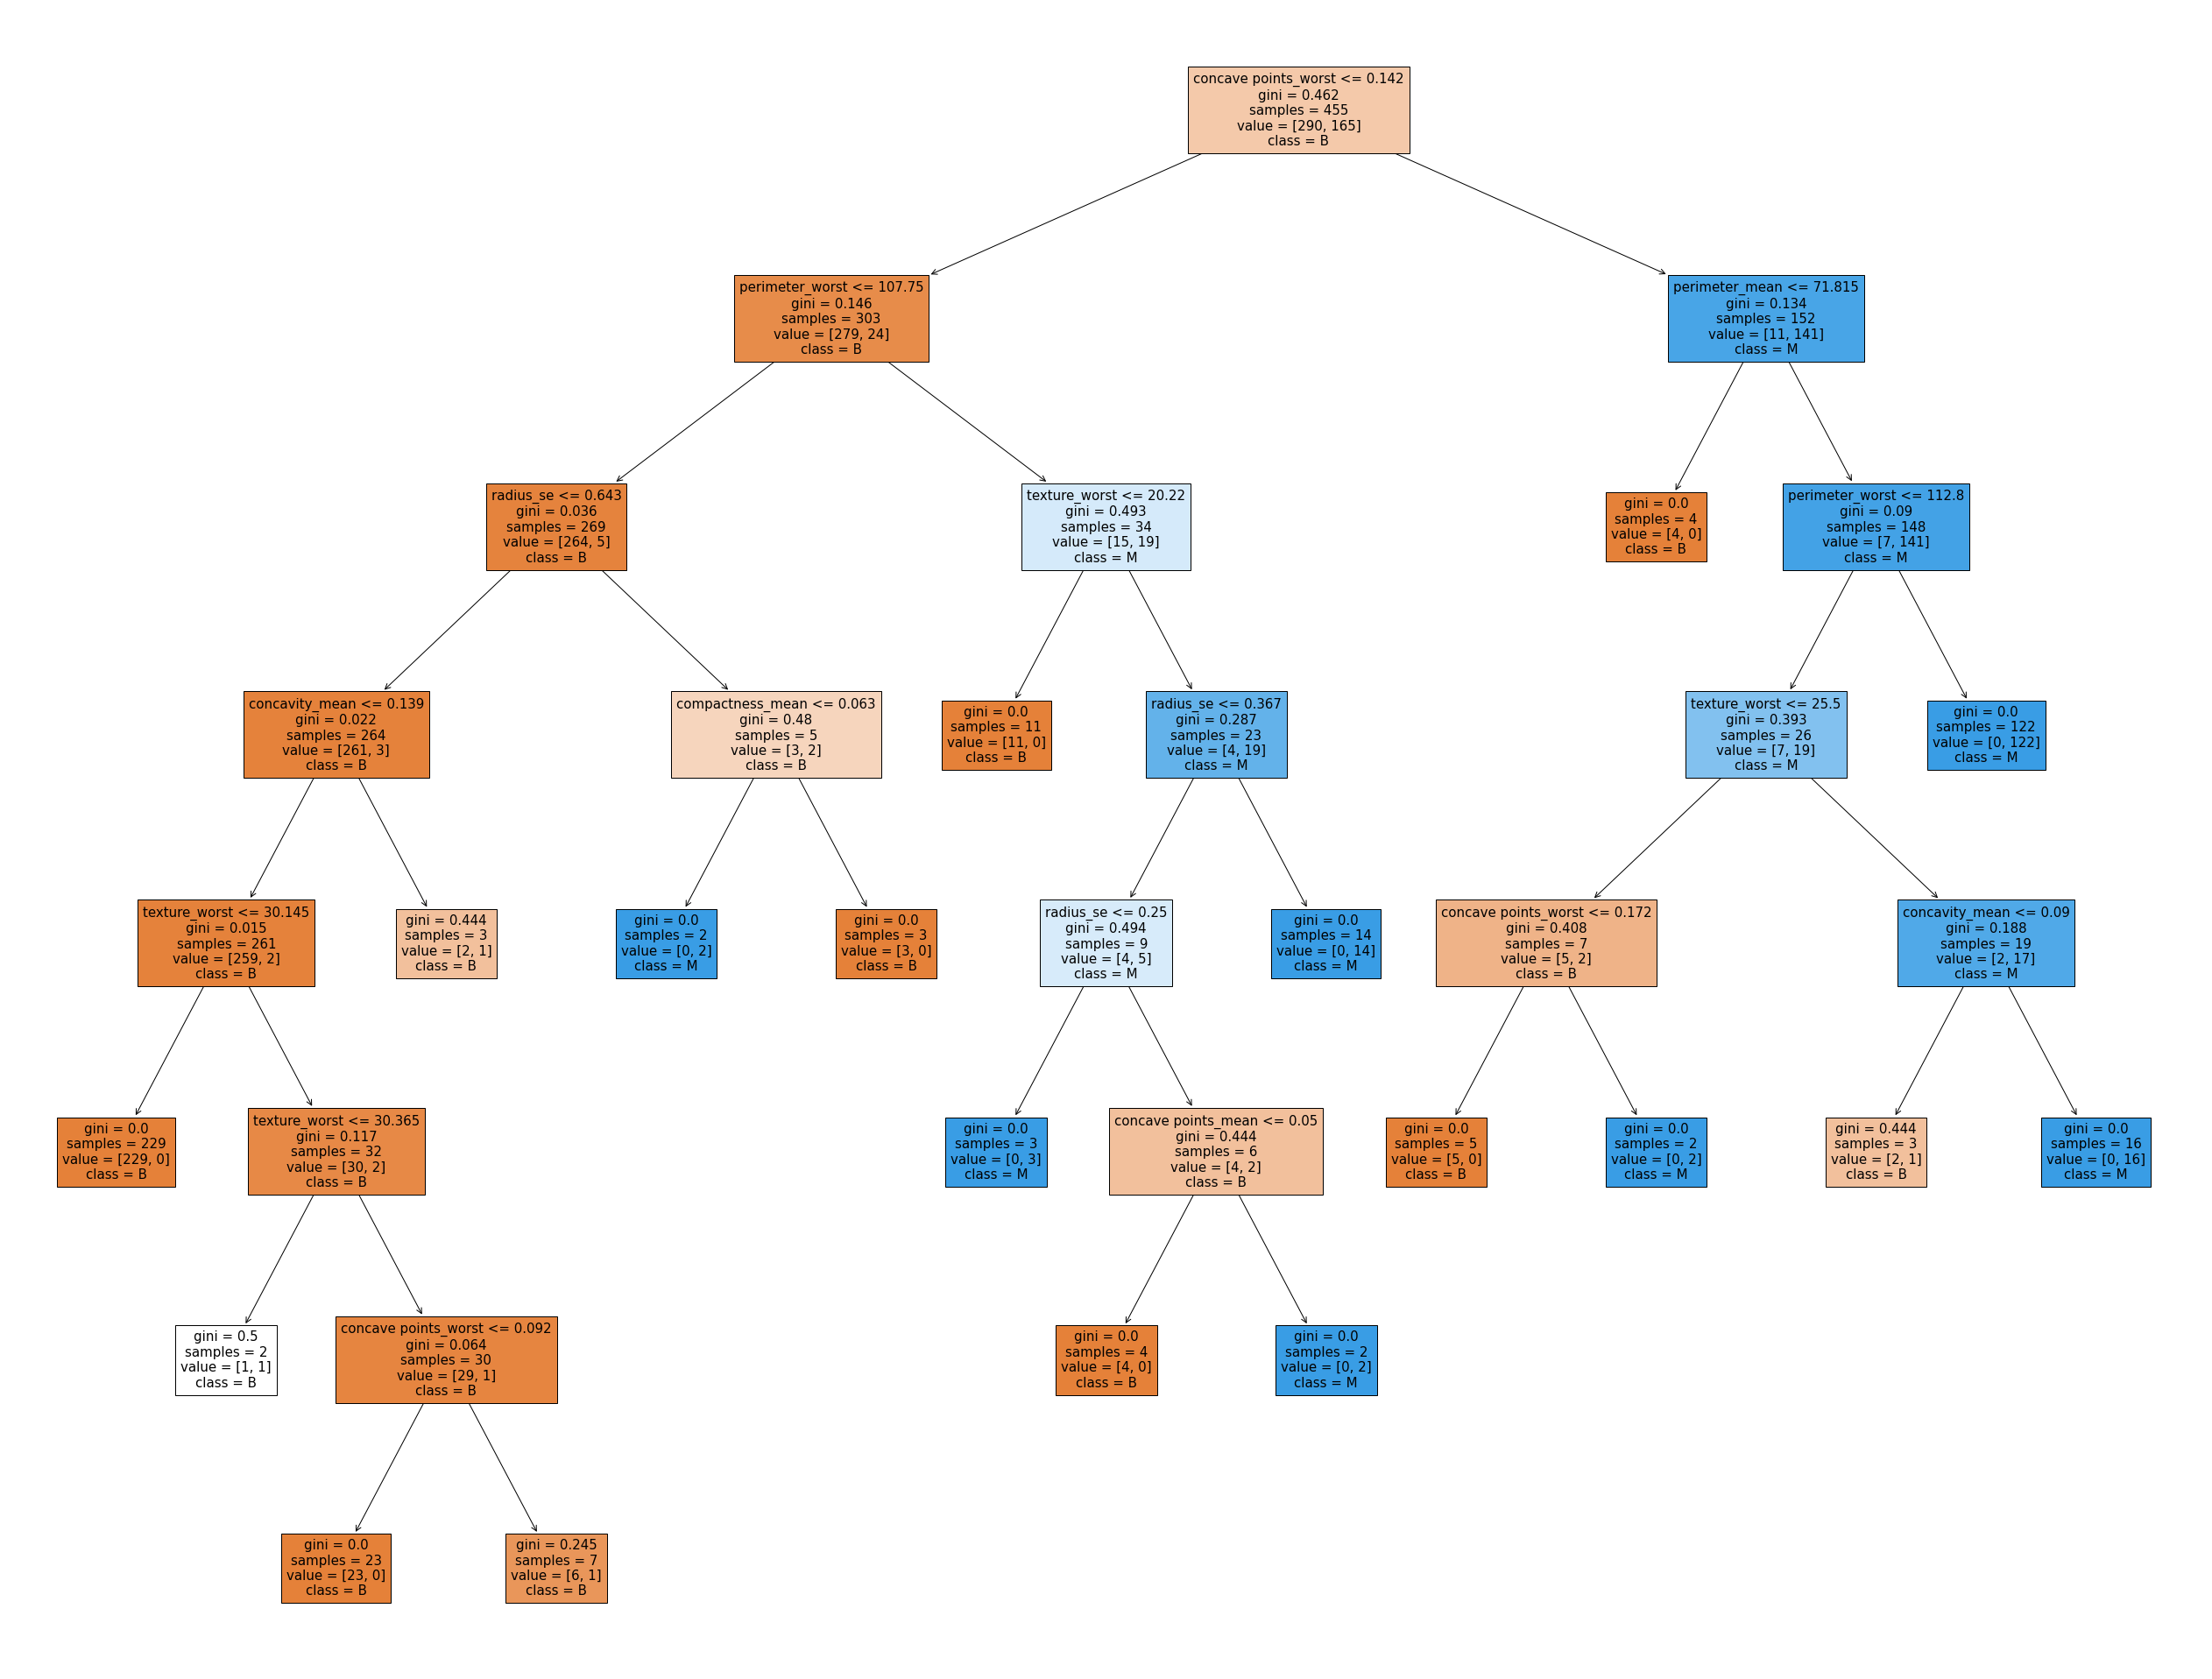

In [51]:
##   ploting best model's tree


fig = plt.figure(figsize=(45,35))
t = plot_tree(
    best_clf,
    feature_names= final_feature_ls,  
    class_names=['B','M'], filled=True
)
fig.savefig('best_model plot.png')

In [52]:
from sklearn.tree import export_text

text_representation = export_text(best_clf,feature_names=final_feature_ls)
print(text_representation)

|--- concave points_worst <= 0.14
|   |--- perimeter_worst <= 107.75
|   |   |--- radius_se <= 0.64
|   |   |   |--- concavity_mean <= 0.14
|   |   |   |   |--- texture_worst <= 30.15
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- texture_worst >  30.15
|   |   |   |   |   |--- texture_worst <= 30.37
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- texture_worst >  30.37
|   |   |   |   |   |   |--- concave points_worst <= 0.09
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- concave points_worst >  0.09
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |--- concavity_mean >  0.14
|   |   |   |   |--- class: 0
|   |   |--- radius_se >  0.64
|   |   |   |--- compactness_mean <= 0.06
|   |   |   |   |--- class: 1
|   |   |   |--- compactness_mean >  0.06
|   |   |   |   |--- class: 0
|   |--- perimeter_worst >  107.75
|   |   |--- texture_worst <= 20.22
|   |   |   |--- class: 0
|   |   |--- texture_worst >  20.22
|   |   |   |--- radius_se

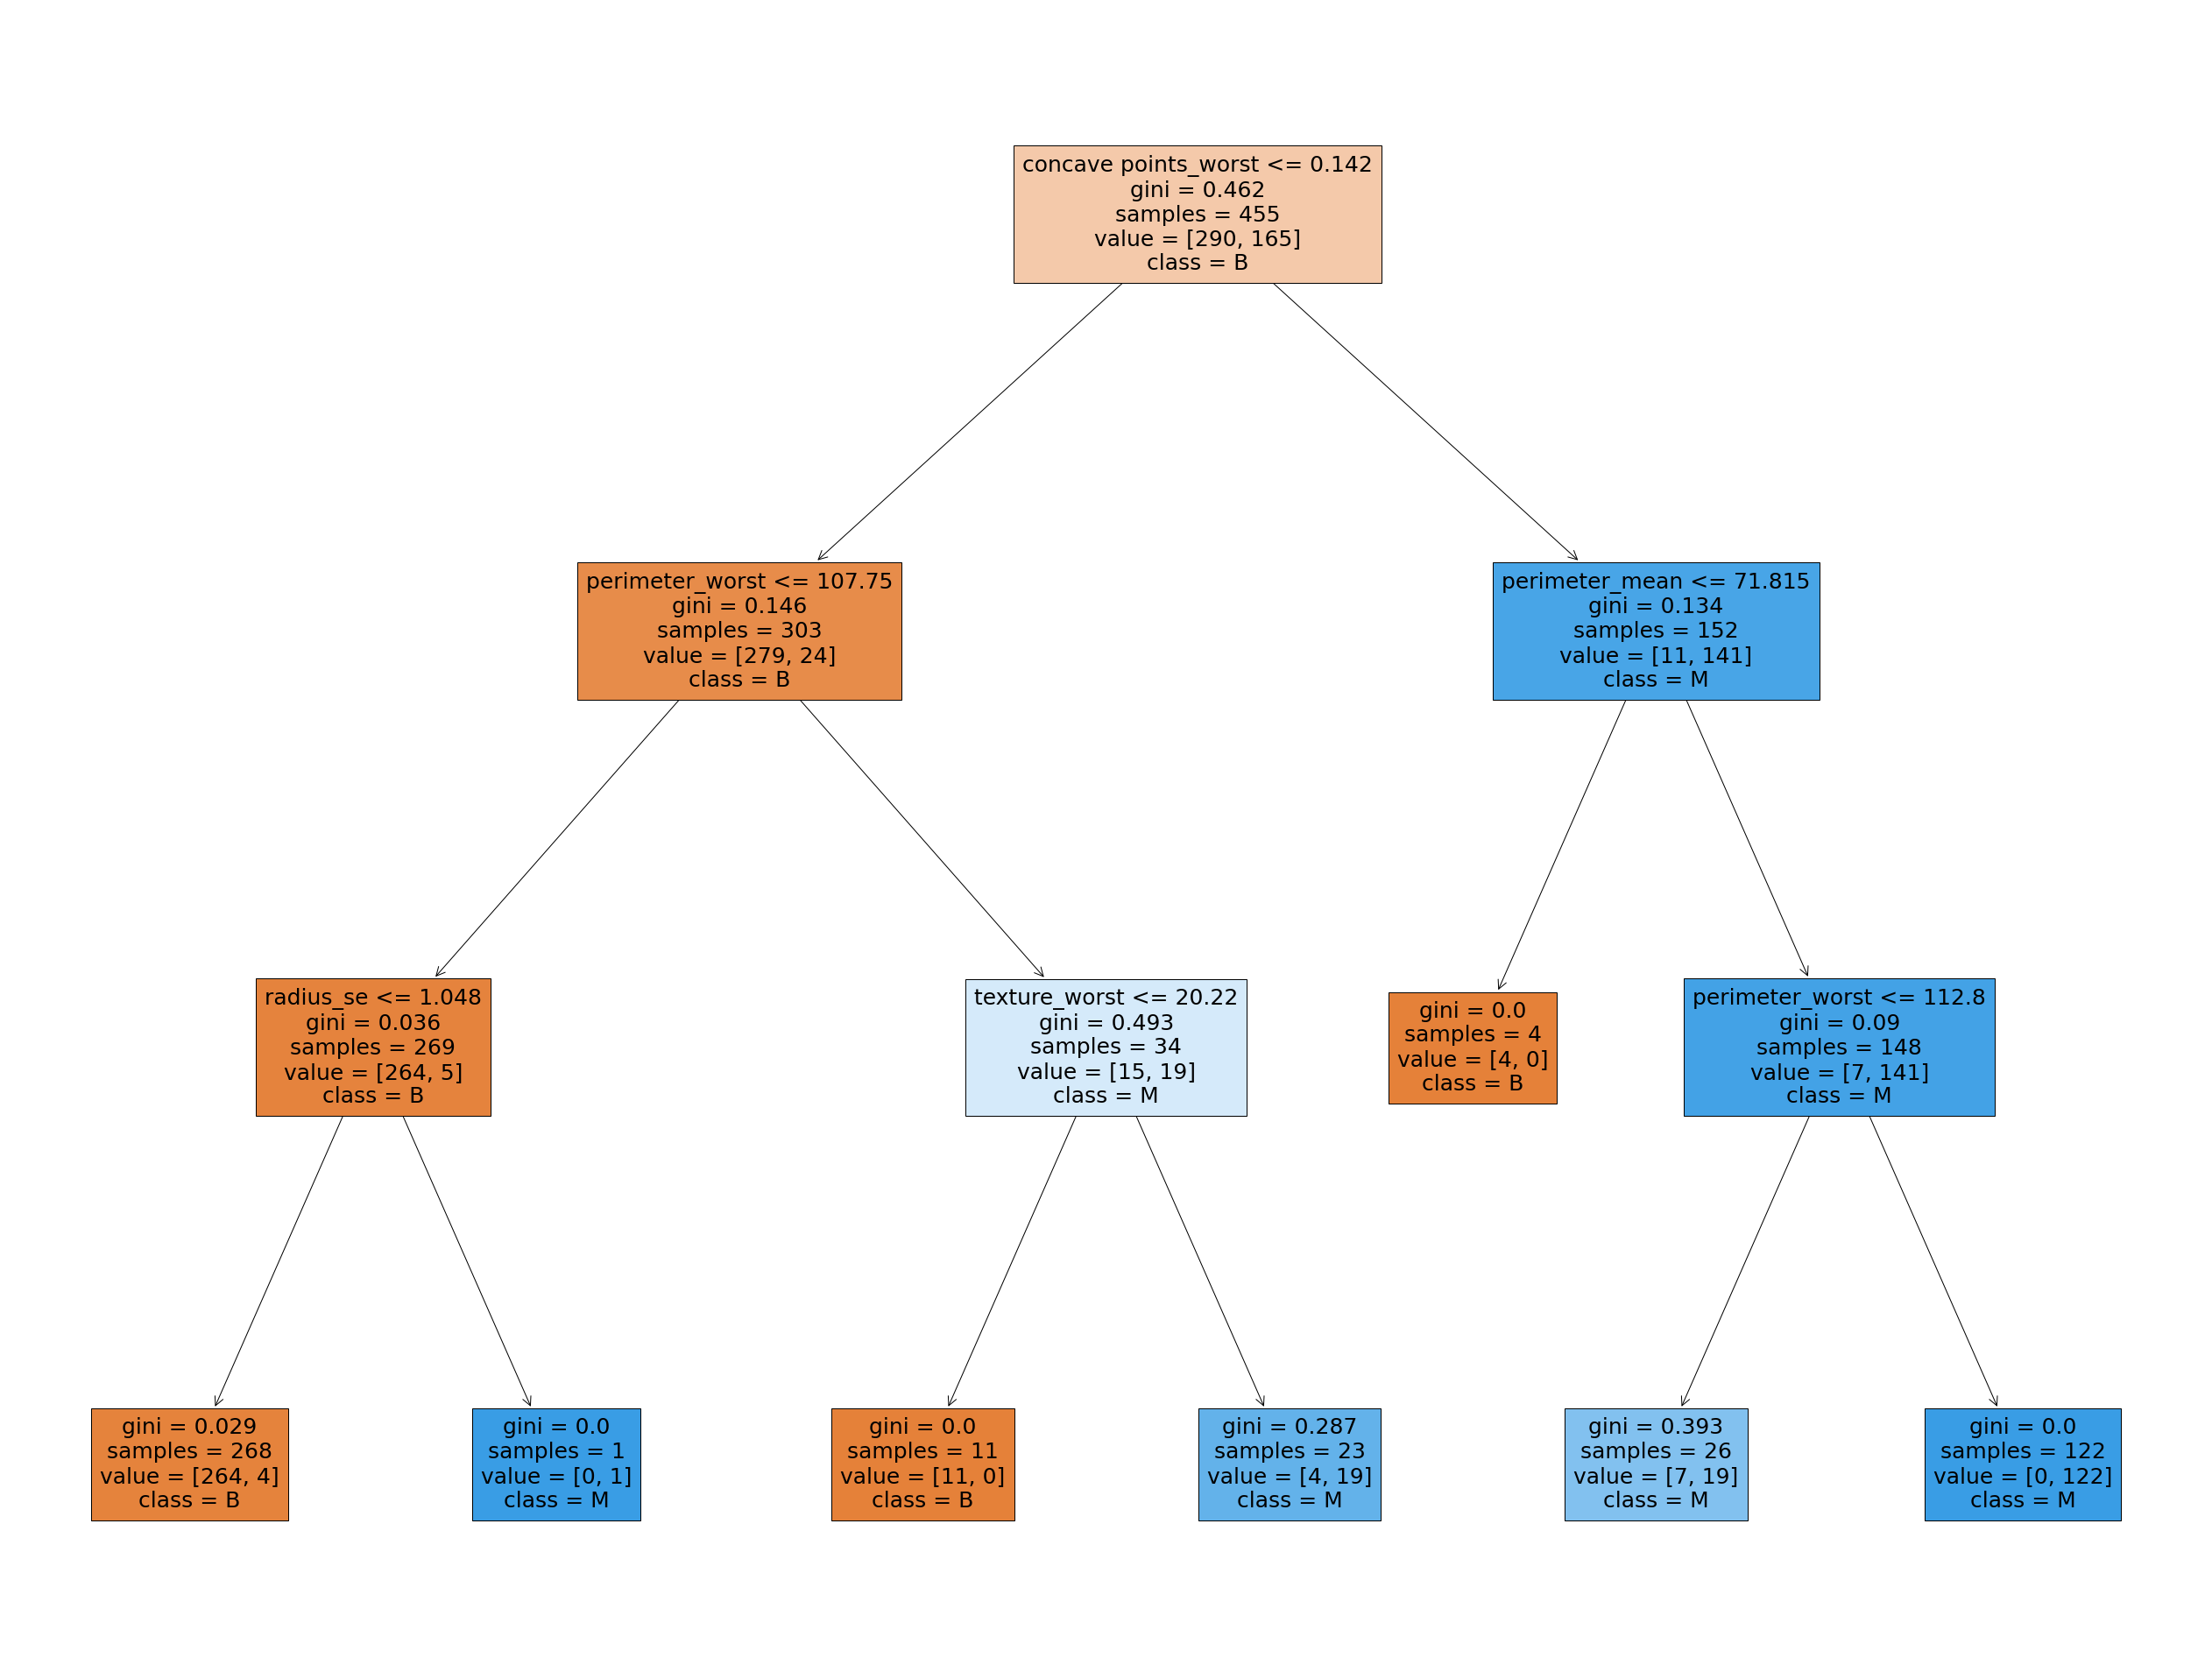

In [53]:
##   ploting best explainable model's tree

fig = plt.figure(figsize=(45,35))
t = plot_tree(
    best_explanable_clf,
    feature_names= final_feature_ls,  
    class_names=['B','M'], filled=True
)

fig.savefig('best_explanable plot.png')

In [54]:
text_representation = export_text(best_explanable_clf,feature_names=final_feature_ls)
print(text_representation)

|--- concave points_worst <= 0.14
|   |--- perimeter_worst <= 107.75
|   |   |--- radius_se <= 1.05
|   |   |   |--- class: 0
|   |   |--- radius_se >  1.05
|   |   |   |--- class: 1
|   |--- perimeter_worst >  107.75
|   |   |--- texture_worst <= 20.22
|   |   |   |--- class: 0
|   |   |--- texture_worst >  20.22
|   |   |   |--- class: 1
|--- concave points_worst >  0.14
|   |--- perimeter_mean <= 71.82
|   |   |--- class: 0
|   |--- perimeter_mean >  71.82
|   |   |--- perimeter_worst <= 112.80
|   |   |   |--- class: 1
|   |   |--- perimeter_worst >  112.80
|   |   |   |--- class: 1



In [55]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sb
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [56]:
list

list

In [57]:
df=pd.read_csv("/content/data.csv")
df=df[list(df.columns)[1:-1]]
df.head()

diagnosis  radius_mean  ...  symmetry_worst  fractal_dimension_worst
0         M        17.99  ...          0.4601                  0.11890
1         M        20.57  ...          0.2750                  0.08902
2         M        19.69  ...          0.3613                  0.08758
3         M        11.42  ...          0.6638                  0.17300
4         M        20.29  ...          0.2364                  0.07678

[5 rows x 31 columns]

In [58]:
# Adding columns highly correlated to target and then removing those highly correlated among each other, we 
# arrive at the same set of features
y=df.diagnosis
y=y.to_numpy()
y=1*(y=='M')
X=df.drop(['diagnosis'],axis=1)
# changed ratio
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)
selected_columns=['radius_mean','perimeter_mean','area_mean','compactness_mean','concavity_mean','concave points_mean','radius_se','perimeter_se','area_se','radius_worst','texture_worst','perimeter_worst','area_worst','compactness_worst','concavity_worst','concave points_worst']
bad_cols=['radius_worst','radius_mean','area_mean','area_worst','perimeter_se','area_se']
X_train_sel,X_test_sel=X_train[selected_columns].drop(bad_cols,axis=1),X_test[selected_columns].drop(bad_cols,axis=1)
# fit scaler on training data
norm = StandardScaler().fit(X_train)
# transform training data
X_train_norm = norm.transform(X_train)
# transform testing dataabs
X_test_norm = norm.transform(X_test)

# fit scaler on training data
norm = StandardScaler().fit(X_train_sel)
# transform training data
X_train_norm_sel = norm.transform(X_train_sel)
# transform testing dataabs
X_test_norm_sel = norm.transform(X_test_sel)

Text(0.5, 1.0, 'Correlation in Features')

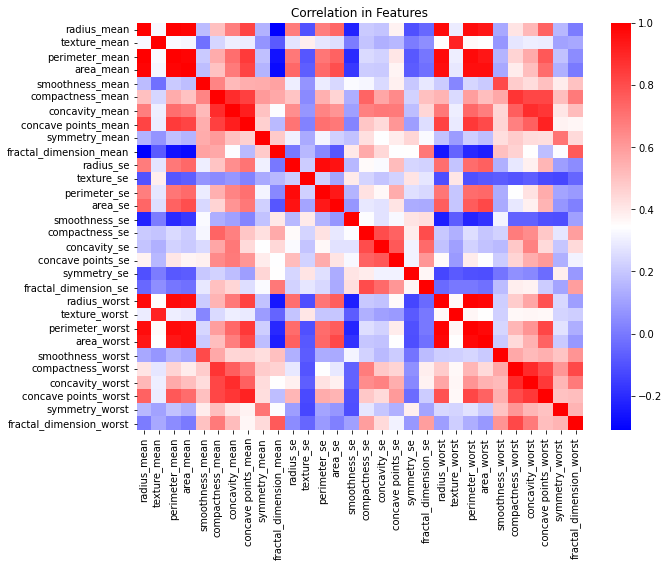

In [59]:
# Heatmap with all features
plt.figure(figsize=(10, 7.5))
matrix = df.corr()
heat = sb.heatmap(matrix, cmap='bwr',annot=False)
heat.set_title('Correlation in Features')

Text(0.5, 1.0, 'Correlation in Features')

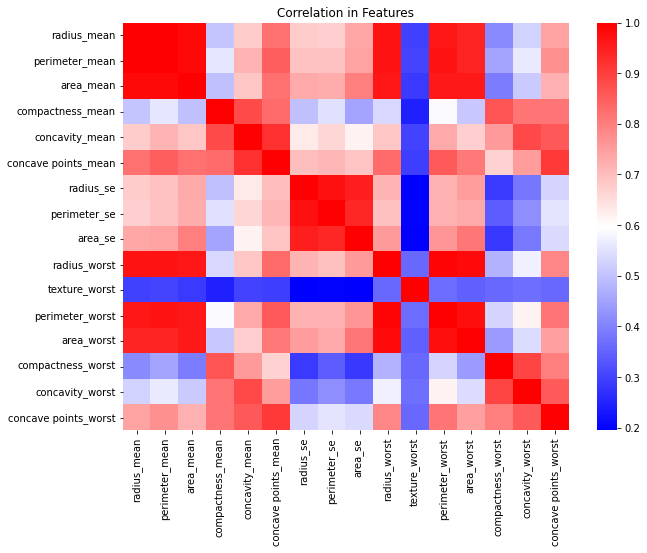

In [60]:
# Heatmap with features highly correlated to target
plt.figure(figsize=(10, 7.5))
matrix = df[selected_columns].corr()
heat = sb.heatmap(matrix, cmap='bwr',annot=False)
heat.set_title('Correlation in Features')

Text(0.5, 1.0, 'Correlation in Features')

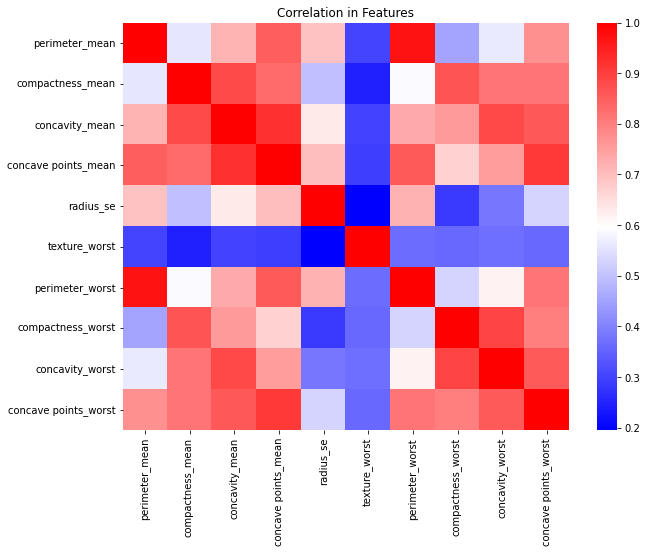

In [61]:
# Heatmap with the final set of features
plt.figure(figsize=(10, 7.5))
matrix = df[selected_columns].drop(bad_cols,axis=1).corr()
heat = sb.heatmap(matrix, cmap='bwr',annot=False) 
heat.set_title('Correlation in Features')
# corr_matrix = X[selected_columns].drop(['radius_worst','radius_mean','area_mean','area_worst','texture_worst'],axis=1).corr().abs()
# threshold = 0.85
# high_corr_var=np.where(corr_matrix>threshold)
# high_corr_var=[(corr_matrix.index[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
# print(high_corr_var)

In [62]:
# Returns a dictionary of metrics given predicted values, true values, and list of classes to cast to {0,1}. 0 is the negative class, 1 is the positive class.
# So in case the classes present are 1,2, pass as [1,2], not [2,1]. It also prints the 5 metrics, confusion matrix, accuracy, precision, recall, F1 score.
# The formulae and variables are self explanatory.
final_majority_array0 = []
final_majority_array1 = []
final_majority_array2 = []
final_majority_array0_train = []
final_majority_array1_train = []
final_majority_array2_train = []
def metrics(y_pred,y_true,classes):
  df = pd.DataFrame(np.random.randn(2, 2), index=["actual1","actual0"], columns=["pred1","pred0"])
  for i in [1,0]:
    for j in [1,0]:
      df["pred"+str(i)]["actual"+str(j)]=((y_pred==classes[i]) & (y_true==classes[j])).sum()
  precision=df["pred1"]["actual1"]/df["pred1"].sum()
  recall=df["pred1"]["actual1"]/df.loc["actual1"].sum()
  accuracy=(df["pred1"]["actual1"]+df["pred0"]["actual0"])/df.sum().sum()
  f1=2*precision*recall/(precision+recall)
  metrs={}
  metrs['confusion matrix']=df
  metrs['accuracy']=accuracy
  metrs['precision']=precision
  metrs['recall']=recall
  metrs['f1_score']=f1
  print("Confusion Matrix: ","\n",df)
  print("Accuracy: ",accuracy)
  print("Precision: ",precision)
  print("Recall: ",recall)
  print("F1 score: ",f1)
  return metrs

In [63]:
pca_initial = PCA()
pcafit = pca_initial.fit_transform(X_train_norm,y_train)
var_explained = pca_initial.explained_variance_ratio_ #ratio of variance each PC explains
###Since 29 components aren't necessary, the last 20 PCs will be disregarded 
###since they explain less than.01 of the variance
print(sum(var_explained[0:2]))

print(sum(var_explained[0:6]))
print(sum(var_explained[0:7]))
print(sum(var_explained[0:10]))
print(sum(var_explained[0:15]))
print(sum(var_explained[0:20]))
print(sum(var_explained[0:30]))
##indeed,the first 10 PCs explain 95% of the variance

0.631708820250351
0.8891438432147124
0.9106363829667494
0.9513318518060244
0.98680793927746
0.995721982530379
1.0000000000000002


In [64]:
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train_norm,y_train)
X_test_pca = pca.transform(X_test_norm)
Xs={}
Xs['set0']=[X_train_norm,X_test_norm,y_train,y_test]
Xs['set1']=[X_train_norm_sel,X_test_norm_sel,y_train,y_test]
Xs['set2']=[X_train_pca,X_test_pca,y_train,y_test]

In [65]:

# 'alpha':[0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1,3],
roc_auc_scores=[]
grids=[]
for i in range(3):
  # X=Xs['set'+str(i)].to_numpy()
  X_train,X_test,y_train,y_test=Xs['set'+str(i)]
  # print(X_train.shape)
  sgdc=SGDClassifier()
  params={'loss':['log'],
          'learning_rate':['constant'],
          'eta0':[0.01,0.03,0.1,0.3,1,3],
          'alpha':[0],
          'random_state':[0]}
  grid=GridSearchCV(sgdc,params)
  
  grid.fit(X_train,y_train)
  sgdc=SGDClassifier(loss='log',verbose=False,alpha=grid.best_params_['alpha'],learning_rate=grid.best_params_['learning_rate'],eta0=grid.best_params_['eta0'],random_state=grid.best_params_['random_state'])
  print(grid.best_params_)
  grids.append(grid.best_params_)
  sgdc.fit(X_train,y_train)
  y_pred=sgdc.predict(X_test)
  y_pred1=sgdc.predict(X_train)
  if(i==0):
    final_majority_array0.append(y_pred)
    final_majority_array0_train.append(y_pred1)
  elif(i==1):
    final_majority_array1.append(y_pred)
    final_majority_array1_train.append(y_pred1)
  elif(i==2):
    final_majority_array2.append(y_pred)
    final_majority_array2_train.append(y_pred1)
  roc_auc_scores.append(roc_auc_score(y_test,y_pred))
  metrics(y_pred,y_test,[0,1])
  metrics(y_pred1,y_train,[0,1])

{'alpha': 0, 'eta0': 0.01, 'learning_rate': 'constant', 'loss': 'log', 'random_state': 0}
Confusion Matrix:  
          pred1  pred0
actual1   44.0    3.0
actual0    2.0   65.0
Accuracy:  0.956140350877193
Precision:  0.9565217391304348
Recall:  0.9361702127659575
F1 score:  0.9462365591397849
Confusion Matrix:  
          pred1  pred0
actual1  161.0    4.0
actual0    1.0  289.0
Accuracy:  0.989010989010989
Precision:  0.9938271604938271
Recall:  0.9757575757575757
F1 score:  0.9847094801223242
{'alpha': 0, 'eta0': 0.01, 'learning_rate': 'constant', 'loss': 'log', 'random_state': 0}
Confusion Matrix:  
          pred1  pred0
actual1   45.0    2.0
actual0    3.0   64.0
Accuracy:  0.956140350877193
Precision:  0.9375
Recall:  0.9574468085106383
F1 score:  0.9473684210526315
Confusion Matrix:  
          pred1  pred0
actual1  156.0    9.0
actual0    6.0  284.0
Accuracy:  0.967032967032967
Precision:  0.9629629629629629
Recall:  0.9454545454545454
F1 score:  0.9541284403669724
{'alpha': 0,

In [66]:
# 'alpha':[0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1,3],
roc_auc_scores=[]
grids=[]
for i in range(3):
  # X=Xs['set'+str(i)].to_numpy()
  X_train,X_test,y_train,y_test=Xs['set'+str(i)]
  # print(X_train.shape)
  ldac=LinearDiscriminantAnalysis(solver='svd')
  ldac.fit(X_train,y_train)
  y_pred=ldac.predict(X_test)
  y_pred1=ldac.predict(X_train)
  if(i==0):
    final_majority_array0.append(y_pred)
    final_majority_array0_train.append(y_pred1)
  elif(i==1):
    final_majority_array1.append(y_pred)
    final_majority_array1_train.append(y_pred1)
  elif(i==2):
    final_majority_array2.append(y_pred)
    final_majority_array2_train.append(y_pred1)

  roc_auc_scores.append(roc_auc_score(y_test,y_pred))
  final_majority_array0_train.append(y_pred1)
  metrics(y_pred,y_test,[0,1])
  metrics(y_pred1,y_train,[0,1])

Confusion Matrix:  
          pred1  pred0
actual1   43.0    4.0
actual0    0.0   67.0
Accuracy:  0.9649122807017544
Precision:  1.0
Recall:  0.9148936170212766
F1 score:  0.9555555555555556
Confusion Matrix:  
          pred1  pred0
actual1  149.0   16.0
actual0    1.0  289.0
Accuracy:  0.9626373626373627
Precision:  0.9933333333333333
Recall:  0.9030303030303031
F1 score:  0.946031746031746
Confusion Matrix:  
          pred1  pred0
actual1   42.0    5.0
actual0    1.0   66.0
Accuracy:  0.9473684210526315
Precision:  0.9767441860465116
Recall:  0.8936170212765957
F1 score:  0.9333333333333332
Confusion Matrix:  
          pred1  pred0
actual1  145.0   20.0
actual0    1.0  289.0
Accuracy:  0.9538461538461539
Precision:  0.9931506849315068
Recall:  0.8787878787878788
F1 score:  0.9324758842443731
Confusion Matrix:  
          pred1  pred0
actual1   42.0    5.0
actual0    0.0   67.0
Accuracy:  0.956140350877193
Precision:  1.0
Recall:  0.8936170212765957
F1 score:  0.9438202247191011
Co

In [67]:
# 'alpha':[0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1,3],
roc_auc_scores=[]
grids=[]
for i in range(3):
  # X=Xs['set'+str(i)].to_numpy()
  X_train,X_test,y_train,y_test=Xs['set'+str(i)]
  # print(X_train.shape)
  
  qdac=QuadraticDiscriminantAnalysis()
  qdac.fit(X_train,y_train)
  y_pred=qdac.predict(X_test)
  y_pred1=qdac.predict(X_train)
  if(i==0):
    final_majority_array0.append(y_pred)
    final_majority_array0_train.append(y_pred1)
  elif(i==1):
    final_majority_array1.append(y_pred)
    final_majority_array1_train.append(y_pred1)
  elif(i==2):
    final_majority_array2.append(y_pred)
    final_majority_array2_train.append(y_pred1)
  roc_auc_scores.append(roc_auc_score(y_test,y_pred))
  metrics(y_pred,y_test,[0,1])
  metrics(y_pred1,y_train,[0,1])

Confusion Matrix:  
          pred1  pred0
actual1   45.0    2.0
actual0    3.0   64.0
Accuracy:  0.956140350877193
Precision:  0.9375
Recall:  0.9574468085106383
F1 score:  0.9473684210526315
Confusion Matrix:  
          pred1  pred0
actual1  157.0    8.0
actual0    4.0  286.0
Accuracy:  0.9736263736263736
Precision:  0.9751552795031055
Recall:  0.9515151515151515
F1 score:  0.9631901840490796
Confusion Matrix:  
          pred1  pred0
actual1   44.0    3.0
actual0    2.0   65.0
Accuracy:  0.956140350877193
Precision:  0.9565217391304348
Recall:  0.9361702127659575
F1 score:  0.9462365591397849
Confusion Matrix:  
          pred1  pred0
actual1  152.0   13.0
actual0    8.0  282.0
Accuracy:  0.9538461538461539
Precision:  0.95
Recall:  0.9212121212121213
F1 score:  0.9353846153846154
Confusion Matrix:  
          pred1  pred0
actual1   43.0    4.0
actual0    1.0   66.0
Accuracy:  0.956140350877193
Precision:  0.9772727272727273
Recall:  0.9148936170212766
F1 score:  0.945054945054945


In [68]:
# final 10 feature in the correlation dataset
# wisconsin = df

# final_feature_ls = ['perimeter_mean','compactness_mean', 'concavity_mean', 'concave points_mean', 'radius_se',
#                     'texture_worst', 'perimeter_worst', 'compactness_worst', 'concavity_worst','concave points_worst']

# # wisconsin is the pandas dataframe returned after reading 'data.csv'
# # and removing the 'id' and 'Unnamed32' column from it , shape = (569, 31)
# X = wisconsin[final_feature_ls]         # could be data in place of wisconsin           
# y = wisconsin["diagnosis"]  

# y = y.to_numpy()
# X = X.to_numpy()

# y=1*(y=='M')      # 1 = M  and  0 = B

# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)
# X_train.shape,X_test.shape,y_train.shape,y_test.shape 
              

In [69]:
best_param_DT = {'criterion': 'gini',
  'max_depth': 7,
  'min_samples_leaf': 2,
  'random_state': 0}

best_param_DT

{'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 2, 'random_state': 0}

In [70]:
for i in range(3):
  X_train,X_test,y_train,y_test=Xs['set'+str(i)] 
   
  best_clf = DecisionTreeClassifier(
  criterion= best_param_DT['criterion'],
  max_depth= best_param_DT['max_depth'],
  min_samples_leaf= best_param_DT['min_samples_leaf'],
  random_state= best_param_DT['random_state'])
  best_clf.fit(X_train,y_train)
  pred = best_clf.predict(X_test)
  pred1 = best_clf.predict(X_train)
  if(i==0):
    final_majority_array0.append(pred)
    final_majority_array0_train.append(pred1)
  elif(i==1):
    final_majority_array1.append(pred)
    final_majority_array1_train.append(pred1)
  elif(i==2):
    final_majority_array2.append(pred)
    final_majority_array2_train.append(pred1)
  metrics(pred,y_test,[0,1])
  metrics(pred1,y_train,[0,1])


Confusion Matrix:  
          pred1  pred0
actual1   44.0    3.0
actual0    3.0   64.0
Accuracy:  0.9473684210526315
Precision:  0.9361702127659575
Recall:  0.9361702127659575
F1 score:  0.9361702127659575
Confusion Matrix:  
          pred1  pred0
actual1  162.0    3.0
actual0    0.0  290.0
Accuracy:  0.9934065934065934
Precision:  1.0
Recall:  0.9818181818181818
F1 score:  0.9908256880733944
Confusion Matrix:  
          pred1  pred0
actual1   45.0    2.0
actual0    2.0   65.0
Accuracy:  0.9649122807017544
Precision:  0.9574468085106383
Recall:  0.9574468085106383
F1 score:  0.9574468085106385
Confusion Matrix:  
          pred1  pred0
actual1  161.0    4.0
actual0    0.0  290.0
Accuracy:  0.9912087912087912
Precision:  1.0
Recall:  0.9757575757575757
F1 score:  0.9877300613496933
Confusion Matrix:  
          pred1  pred0
actual1   43.0    4.0
actual0    3.0   64.0
Accuracy:  0.9385964912280702
Precision:  0.9347826086956522
Recall:  0.9148936170212766
F1 score:  0.924731182795699
C

In [71]:
best_param_RF = {'criterion': 'gini',
  'max_depth': 7,
  'min_samples_leaf': 2,
  'random_state': 0}
best_param_RF

{'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 2, 'random_state': 0}

In [72]:
from sklearn.ensemble import RandomForestClassifier
for i in range(3):
  X_train,X_test,y_train,y_test=Xs['set'+str(i)]  
  # best_clf = RandomForestClassifier(
  # oob_score=True,
  # n_estimators=100,
  # criterion= best_param_RF['criterion'],
  # max_depth= best_param_RF['max_depth'],
  # random_state= best_param_RF['random_state'])
  best_clf= RandomForestClassifier(random_state=0,  oob_score=True,max_depth=2)
  best_clf.fit(X_train,y_train)
  pred = best_clf.predict(X_test)
  pred1 = best_clf.predict(X_train)
  metrics(pred,y_test,[0,1])
  print("hello")
  metrics(pred1,y_train,[0,1])

Confusion Matrix:  
          pred1  pred0
actual1   44.0    3.0
actual0    2.0   65.0
Accuracy:  0.956140350877193
Precision:  0.9565217391304348
Recall:  0.9361702127659575
F1 score:  0.9462365591397849
hello
Confusion Matrix:  
          pred1  pred0
actual1  150.0   15.0
actual0    4.0  286.0
Accuracy:  0.9582417582417583
Precision:  0.974025974025974
Recall:  0.9090909090909091
F1 score:  0.9404388714733543
Confusion Matrix:  
          pred1  pred0
actual1   42.0    5.0
actual0    2.0   65.0
Accuracy:  0.9385964912280702
Precision:  0.9545454545454546
Recall:  0.8936170212765957
F1 score:  0.9230769230769231
hello
Confusion Matrix:  
          pred1  pred0
actual1  148.0   17.0
actual0    5.0  285.0
Accuracy:  0.9516483516483516
Precision:  0.9673202614379085
Recall:  0.896969696969697
F1 score:  0.930817610062893
Confusion Matrix:  
          pred1  pred0
actual1   41.0    6.0
actual0    4.0   63.0
Accuracy:  0.9122807017543859
Precision:  0.9111111111111111
Recall:  0.872340425

In [73]:
best_param_ABC = {'criterion': 'gini',
  'max_depth': 3,
  'min_samples_leaf': 2,
  'random_state': 0, 'n_estimators':100,
  'dt ': DecisionTreeClassifier(min_samples_leaf=2,max_depth=2,random_state=0)
  }
best_param_ABC

{'criterion': 'gini',
 'dt ': DecisionTreeClassifier(max_depth=2, min_samples_leaf=2, random_state=0),
 'max_depth': 3,
 'min_samples_leaf': 2,
 'n_estimators': 100,
 'random_state': 0}

In [74]:
from sklearn.ensemble import AdaBoostClassifier
for i in range(3):
  X_train,X_test,y_train,y_test=Xs['set'+str(i)]  
  best_clf = AdaBoostClassifier(
  base_estimator = DecisionTreeClassifier(min_samples_leaf=2,max_depth=2,random_state=0), 
  random_state= best_param_ABC['random_state'],
  n_estimators=100)
  best_clf.fit(X_train,y_train)
  pred = best_clf.predict(X_test)
  pred1 = best_clf.predict(X_train)
  metrics(pred,y_test,[0,1])
  metrics(pred1,y_train,[0,1])

Confusion Matrix:  
          pred1  pred0
actual1   44.0    3.0
actual0    3.0   64.0
Accuracy:  0.9473684210526315
Precision:  0.9361702127659575
Recall:  0.9361702127659575
F1 score:  0.9361702127659575
Confusion Matrix:  
          pred1  pred0
actual1  165.0    0.0
actual0    0.0  290.0
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1 score:  1.0
Confusion Matrix:  
          pred1  pred0
actual1   45.0    2.0
actual0    1.0   66.0
Accuracy:  0.9736842105263158
Precision:  0.9782608695652174
Recall:  0.9574468085106383
F1 score:  0.967741935483871
Confusion Matrix:  
          pred1  pred0
actual1  165.0    0.0
actual0    0.0  290.0
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1 score:  1.0
Confusion Matrix:  
          pred1  pred0
actual1   42.0    5.0
actual0    2.0   65.0
Accuracy:  0.9385964912280702
Precision:  0.9545454545454546
Recall:  0.8936170212765957
F1 score:  0.9230769230769231
Confusion Matrix:  
          pred1  pred0
actual1  165.0    0.0
actual0    0.0  290.0
Accu

In [75]:
def find_majority(input_list):
  from scipy.stats import mode
  result = mode(input_list)[0]
  final_result = np.transpose(result).flatten()
  return final_result



In [76]:
for i in range(0,len(final_majority_array0)):
  print(final_majority_array0[i].shape)
  final_majority_array0[i] = (np.asarray(final_majority_array0[i]).astype(int))

(114,)
(114,)
(114,)
(114,)


In [77]:
for i in range(0,len(final_majority_array1)):
  print(final_majority_array1[i].shape)
  final_majority_array1[i] = (np.asarray(final_majority_array1[i]).astype(int))

(114,)
(114,)
(114,)
(114,)


In [78]:
for i in range(0,len(final_majority_array2)):
  print(final_majority_array2[i].shape)
  final_majority_array2[i] = (np.asarray(final_majority_array2[i]).astype(int))

(114,)
(114,)
(114,)
(114,)


In [79]:
print((final_majority_array2))

[array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 0]), array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 0]), array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       1

In [80]:
y_pred0 = (find_majority(final_majority_array0))
metrics(y_pred0,y_test,[0,1])
y_pred0_train = (find_majority(final_majority_array0_train))
metrics(y_pred0_train,y_train,[0,1])

Confusion Matrix:  
          pred1  pred0
actual1   44.0    3.0
actual0    1.0   66.0
Accuracy:  0.9649122807017544
Precision:  0.9777777777777777
Recall:  0.9361702127659575
F1 score:  0.9565217391304347
Confusion Matrix:  
          pred1  pred0
actual1  153.0   12.0
actual0    1.0  289.0
Accuracy:  0.9714285714285714
Precision:  0.9935064935064936
Recall:  0.9272727272727272
F1 score:  0.9592476489028213


{'accuracy': 0.9714285714285714, 'confusion matrix':          pred1  pred0
 actual1  153.0   12.0
 actual0    1.0  289.0, 'f1_score': 0.9592476489028213, 'precision': 0.9935064935064936, 'recall': 0.9272727272727272}

In [81]:
y_pred1 = (find_majority(final_majority_array1))
metrics(y_pred1,y_test,[0,1])
y_pred1_train = (find_majority(final_majority_array1_train))
metrics(y_pred1_train,y_train,[0,1])

Confusion Matrix:  
          pred1  pred0
actual1   44.0    3.0
actual0    1.0   66.0
Accuracy:  0.9649122807017544
Precision:  0.9777777777777777
Recall:  0.9361702127659575
F1 score:  0.9565217391304347
Confusion Matrix:  
          pred1  pred0
actual1  152.0   13.0
actual0    0.0  290.0
Accuracy:  0.9714285714285714
Precision:  1.0
Recall:  0.9212121212121213
F1 score:  0.9589905362776024


{'accuracy': 0.9714285714285714, 'confusion matrix':          pred1  pred0
 actual1  152.0   13.0
 actual0    0.0  290.0, 'f1_score': 0.9589905362776024, 'precision': 1.0, 'recall': 0.9212121212121213}

In [82]:
y_pred2 = (find_majority(final_majority_array2))
metrics(y_pred2,y_test,[0,1])
y_pred2_train = (find_majority(final_majority_array2_train))
metrics(y_pred2_train,y_train,[0,1])

Confusion Matrix:  
          pred1  pred0
actual1   43.0    4.0
actual0    0.0   67.0
Accuracy:  0.9649122807017544
Precision:  1.0
Recall:  0.9148936170212766
F1 score:  0.9555555555555556
Confusion Matrix:  
          pred1  pred0
actual1  157.0    8.0
actual0    0.0  290.0
Accuracy:  0.9824175824175824
Precision:  1.0
Recall:  0.9515151515151515
F1 score:  0.9751552795031055


{'accuracy': 0.9824175824175824, 'confusion matrix':          pred1  pred0
 actual1  157.0    8.0
 actual0    0.0  290.0, 'f1_score': 0.9751552795031055, 'precision': 1.0, 'recall': 0.9515151515151515}

In [83]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

In [84]:
# # for dataset-2
# def append_metric(ls1,ls2,ls3,ls4,test,pred):
#   ls1.append(  accuracy_score(test,pred) )
#   ls2.append(  precision_score(test,pred) )
#   ls3.append(  recall_score(test,pred) )
#   ls4.append(  f1_score(test,pred) )

# accuracies, precisions, recalls, f1s  = [],[],[],[]

# X_train,X_test,y_train,y_test=Xs['set'+str(1)]

# ldac=LinearDiscriminantAnalysis(solver='svd')
# ldac.fit(X_train,y_train)
# y_pred=ldac.predict(X_test)
# append_metric( accuracies, precisions, recalls, f1s, y_test, y_pred )


# qdac=QuadraticDiscriminantAnalysis()
# qdac.fit(X_train,y_train)
# y_pred=qdac.predict(X_test) 
# append_metric( accuracies, precisions, recalls, f1s, y_test, y_pred )


# best_clf = DecisionTreeClassifier(
#     criterion= best_param_DT['criterion'],
#     max_depth= best_param_DT['max_depth'],
#     min_samples_leaf= best_param_DT['min_samples_leaf'],
#     random_state= best_param_DT['random_state']
#   )
# best_clf.fit(X_train,y_train)
# y_pred = best_clf.predict(X_test)
# append_metric( accuracies, precisions, recalls, f1s, y_test,y_pred )


# sgdc=SGDClassifier(loss='log',verbose=False,alpha=grid.best_params_['alpha'],learning_rate=grid.best_params_['learning_rate'],eta0=grid.best_params_['eta0'],random_state=grid.best_params_['random_state'])
# sgdc.fit(X_train,y_train)
# y_pred=sgdc.predict(X_test)
# append_metric( accuracies, precisions, recalls, f1s, y_test, y_pred )

# # for regression
# accuracies.append(accuracy)
# recalls.append(recall)
# f1s.append(f1)
# precisions.append(precision)


# plt.figure(figsize=(15,8))

# x = np.arange(1,6)
# width = 0.2
# plt.bar(x-0.2,accuracies,width,color='#ff6361')
# plt.bar(x,precisions,width,color='cyan')
# plt.bar(x+0.2,recalls,width,color='#ffa600')
# plt.bar(x+0.4,f1s,width,color='#bc5090')

# plt.title('Metrics scores for different Classifier for correlation based dataset')
# plt.xticks(x, ['LDA', 'QDA', 'Decision Tree', 'Logistic Regression','Linear Regression'])
# plt.xlabel("Classifiers")
# plt.ylabel("Metric Scores")
# plt.legend(["Accracy", "Precision", "Recall","f1"])


In [85]:
# # for dataset-2
# def append_metric(ls1,ls2,ls3,ls4,test,pred):
#   ls1.append(  accuracy_score(test,pred) )
#   ls2.append(  precision_score(test,pred) )
#   ls3.append(  recall_score(test,pred) )
#   ls4.append(  f1_score(test,pred) )

# def write_Val(ps):
#   # for i in range(len(x)):
#   #   plt.text(x[i], y[i]//2, y[i])
#   for p in ps.patches:
#     ps.annotate(format(p.get_height(), '.1f'), 
#                     (p.get_x() + p.get_width() / 2., p.get_height()), 
#                     ha = 'center', va = 'center', 
#                     xytext = (0, 9), 
#                     textcoords = 'offset points')
#   # for index, value in enumerate(y):
#     # plt.text(value, index, str(value))
#     # plt.text(i, recalls[i]//2, recalls[i], ha = 'center')
#     # plt.text(i, precisions[i]//2, precisions[i], ha = 'center')
#     # plt.text(i, f1s[i]//2, f1s[i], ha = 'center')

# accuracies, precisions, recalls, f1s  = [],[],[],[]

# X_train,X_test,y_train,y_test=Xs['set'+str(2)]

# ldac=LinearDiscriminantAnalysis(solver='svd')
# ldac.fit(X_train,y_train)
# y_pred=ldac.predict(X_test)
# append_metric( accuracies, precisions, recalls, f1s, y_test, y_pred )


# qdac=QuadraticDiscriminantAnalysis()
# qdac.fit(X_train,y_train)
# y_pred=qdac.predict(X_test) 
# append_metric( accuracies, precisions, recalls, f1s, y_test, y_pred )


# # best_clf = DecisionTreeClassifier(
# #     criterion= best_param_DT['criterion'],
# #     max_depth= best_param_DT['max_depth'],
# #     min_samples_leaf= best_param_DT['min_samples_leaf'],
# #     random_state= best_param_DT['random_state']
# #   )
# # best_clf.fit(X_train,y_train)
# # y_pred = best_clf.predict(X_test)
# # append_metric( accuracies, precisions, recalls, f1s, y_test,y_pred )


# sgdc=SGDClassifier(loss='log',verbose=False,alpha=grid.best_params_['alpha'],learning_rate=grid.best_params_['learning_rate'],eta0=grid.best_params_['eta0'],random_state=grid.best_params_['random_state'])
# sgdc.fit(X_train,y_train)
# y_pred=sgdc.predict(X_test)
# append_metric( accuracies, precisions, recalls, f1s, y_test, y_pred )

# # for regression
# accuracies.append(accuracy)
# recalls.append(recall)
# f1s.append(f1)
# precisions.append(precision)

# plt.figure(figsize=(15,8))
# # fig, ax = plt.subplots()

# x = np.arange(1,5)
# accx,recx,f1x = x-0.2, x+0.2,x+0.4
# width = 0.2

# p1 = plt.bar(accx,accuracies,width,color='#ff6361')
# p2 = plt.bar(x,precisions,width,color='cyan')
# p3 = plt.bar(recx,recalls,width,color='#ffa600')
# p4 = plt.bar(f1x,f1s,width,color='#bc5090')

# # ax.bar_label(p1,label_type='center')
# # write_Val(p1)
# # write_Val(p2)
# # write_Val(p3)
# # write_Val(p4)


# plt.title('Metrics scores for different Classifier for pca based dataset')
# plt.xticks(x, ['LDA', 'QDA', 'Logistic Regression','Linear Regresion'])
# plt.xlabel("Classifiers")
# plt.ylabel("Metric Scores")
# plt.legend(["Accracy", "Precision", "Recall","f1"])


In [86]:
##################
## Linear regression
##################
# len(Xs['set6'].columns)
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

def threshold( y, y_pred):
  accuracy = []
  f1 = []
  precision = []
  recall = []
  threshold = [0.35, 0.4, 0.45, 0.5, 0.55,0.6]
  for i in threshold:
    print(i)
    y_pred_new = (y_pred > i )*1
    accuracy.append( accuracy_score( y, y_pred_new))
    f1.append( f1_score( y, y_pred_new))
    precision.append( precision_score( y, y_pred_new))
    recall.append( recall_score( y, y_pred_new))
  return accuracy, f1, precision, recall

In [87]:
# 'alpha':[0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1,3],
from sklearn.linear_model import SGDRegressor
# roc_auc_scores=[]
grids=[]
for i in range(3):
  # X=Xs['set'+str(i)].to_numpy()
  Xtrain,X_test,y_train,y_test = Xs['set'+str(i)]
  # print(X_train.shape)
  Xtrain_df, Xval_df, Ytrain_df, Yval_df = train_test_split( Xtrain, y_train, test_size=0.2, random_state=42)
  sgdc=SGDRegressor()
  params={'loss':['squared_error'],
          'learning_rate':['constant'],
          'eta0':[0.01,0.03,0.1,0.3,1,3],
          'alpha':[0],
          'random_state':[0]}
  grid = GridSearchCV(sgdc,params)
  grid.fit(Xtrain_df, Ytrain_df)
  sgdc=SGDRegressor(loss='squared_error',verbose=False,alpha=grid.best_params_['alpha'],learning_rate=grid.best_params_['learning_rate'],eta0=grid.best_params_['eta0'],random_state=grid.best_params_['random_state'])
  print( grid.best_params_)
  grids.append( grid.best_params_)
  sgdc.fit( Xtrain_df, Ytrain_df)
  y_pred = sgdc.predict( Xval_df)
  accuracy, f1, precision, recall = threshold(  Yval_df, y_pred )
  print(accuracy, f1, precision, recall)


{'alpha': 0, 'eta0': 0.01, 'learning_rate': 'constant', 'loss': 'squared_error', 'random_state': 0}
0.35
0.4
0.45
0.5
0.55
0.6
[0.9120879120879121, 0.945054945054945, 0.9340659340659341, 0.9340659340659341, 0.9120879120879121, 0.9230769230769231] [0.8974358974358975, 0.9333333333333332, 0.9166666666666667, 0.9166666666666667, 0.8857142857142857, 0.898550724637681] [0.875, 0.9459459459459459, 0.9705882352941176, 0.9705882352941176, 0.96875, 1.0] [0.9210526315789473, 0.9210526315789473, 0.868421052631579, 0.868421052631579, 0.8157894736842105, 0.8157894736842105]
{'alpha': 0, 'eta0': 0.01, 'learning_rate': 'constant', 'loss': 'squared_error', 'random_state': 0}
0.35
0.4
0.45
0.5
0.55
0.6
[0.9120879120879121, 0.945054945054945, 0.945054945054945, 0.9340659340659341, 0.9230769230769231, 0.9010989010989011] [0.9024390243902439, 0.9333333333333332, 0.9315068493150684, 0.9142857142857143, 0.898550724637681, 0.8656716417910448] [0.8409090909090909, 0.9459459459459459, 0.9714285714285714, 1.0, 

In [88]:
# X=Xs['set'+str(i)].to_numpy()
i = 1
Xtrain,X_test,y_train,y_test = Xs['set'+str(i)]
# print(X_train.shape)
sgdc=SGDRegressor()
params={'loss':['squared_error'],
        'learning_rate':['constant'],
        'eta0':[0.01,0.03,0.1,0.3,1,3],
        'alpha':[0],
        'random_state':[0]}
grid = GridSearchCV(sgdc,params)
grid.fit(Xtrain, y_train)
sgdc=SGDRegressor(loss='squared_error',verbose=False,alpha=grid.best_params_['alpha'],learning_rate=grid.best_params_['learning_rate'],eta0=grid.best_params_['eta0'],random_state=grid.best_params_['random_state'])
print( grid.best_params_)
grids.append( grid.best_params_)
sgdc.fit(Xtrain, y_train)
y_pred = sgdc.predict( X_test)
y_pred_new = (y_pred > 0.45 )*1
# accuracy, f1, precision, recall = threshold( y_pred, y_test )
accuracy = ( accuracy_score(  y_test, y_pred_new))
f1 = ( f1_score( y_test, y_pred_new))
precision = ( precision_score( y_test, y_pred_new))
recall = ( recall_score( y_test, y_pred_new))
print(accuracy, f1, precision, recall)

{'alpha': 0, 'eta0': 0.01, 'learning_rate': 'constant', 'loss': 'squared_error', 'random_state': 0}
0.9385964912280702 0.924731182795699 0.9347826086956522 0.9148936170212766


In [89]:
# X=Xs['set'+str(i)].to_numpy()
i = 2
Xtrain,X_test,y_train,y_test = Xs['set'+str(i)]
# print(X_train.shape)
sgdc=SGDRegressor()
params={'loss':['squared_error'],
        'learning_rate':['constant'],
        'eta0':[0.01,0.03,0.1,0.3,1,3],
        'alpha':[0],
        'random_state':[0]}
grid = GridSearchCV(sgdc,params)
grid.fit(Xtrain, y_train)
sgdc=SGDRegressor(loss='squared_error',verbose=False,alpha=grid.best_params_['alpha'],learning_rate=grid.best_params_['learning_rate'],eta0=grid.best_params_['eta0'],random_state=grid.best_params_['random_state'])
print( grid.best_params_)
grids.append( grid.best_params_)
sgdc.fit(Xtrain, y_train)
y_pred = sgdc.predict( X_test)
y_pred_new = (y_pred > 0.45 )*1
# accuracy, f1, precision, recall = threshold( y_pred, y_test )
accuracy = ( accuracy_score( y_test, y_pred_new))
f1 = ( f1_score( y_test, y_pred_new))
precision = ( precision_score( y_test, y_pred_new))
recall = ( recall_score( y_test, y_pred_new))
print(accuracy, f1, precision, recall)

{'alpha': 0, 'eta0': 0.01, 'learning_rate': 'constant', 'loss': 'squared_error', 'random_state': 0}
0.9473684210526315 0.9318181818181819 1.0 0.8723404255319149


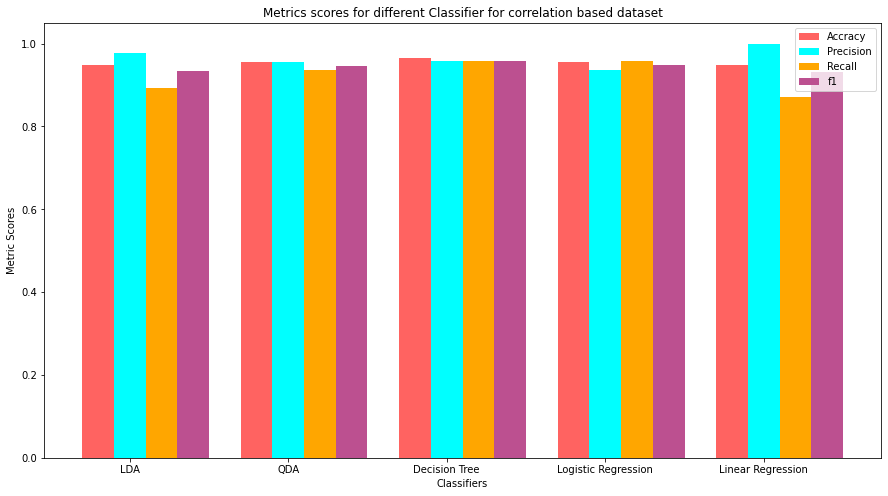

In [90]:
# for dataset-2
def append_metric(ls1,ls2,ls3,ls4,test,pred):
  ls1.append(  accuracy_score(test,pred) )
  ls2.append(  precision_score(test,pred) )
  ls3.append(  recall_score(test,pred) )
  ls4.append(  f1_score(test,pred) )

accuracies, precisions, recalls, f1s  = [],[],[],[]

X_train,X_test,y_train,y_test=Xs['set'+str(1)]

ldac=LinearDiscriminantAnalysis(solver='svd')
ldac.fit(X_train,y_train)
y_pred=ldac.predict(X_test)
append_metric( accuracies, precisions, recalls, f1s, y_test, y_pred )


qdac=QuadraticDiscriminantAnalysis()
qdac.fit(X_train,y_train)
y_pred=qdac.predict(X_test) 
append_metric( accuracies, precisions, recalls, f1s, y_test, y_pred )


best_clf = DecisionTreeClassifier(
    criterion= best_param_DT['criterion'],
    max_depth= best_param_DT['max_depth'],
    min_samples_leaf= best_param_DT['min_samples_leaf'],
    random_state= best_param_DT['random_state']
  )
best_clf.fit(X_train,y_train)
y_pred = best_clf.predict(X_test)
append_metric( accuracies, precisions, recalls, f1s, y_test,y_pred )


sgdc=SGDClassifier(loss='log',verbose=False,alpha=grid.best_params_['alpha'],learning_rate=grid.best_params_['learning_rate'],eta0=grid.best_params_['eta0'],random_state=grid.best_params_['random_state'])
sgdc.fit(X_train,y_train)
y_pred=sgdc.predict(X_test)
append_metric( accuracies, precisions, recalls, f1s, y_test, y_pred )

# for regression
accuracies.append(accuracy)
recalls.append(recall)
f1s.append(f1)
precisions.append(precision)


plt.figure(figsize=(15,8))

x = np.arange(1,6)
width = 0.2
plt.bar(x-0.2,accuracies,width,color='#ff6361')
plt.bar(x,precisions,width,color='cyan')
plt.bar(x+0.2,recalls,width,color='#ffa600')
plt.bar(x+0.4,f1s,width,color='#bc5090')

plt.title('Metrics scores for different Classifier for correlation based dataset')
plt.xticks(x, ['LDA', 'QDA', 'Decision Tree', 'Logistic Regression','Linear Regression'])
plt.xlabel("Classifiers")
plt.ylabel("Metric Scores")
plt.legend(["Accracy", "Precision", "Recall","f1"])


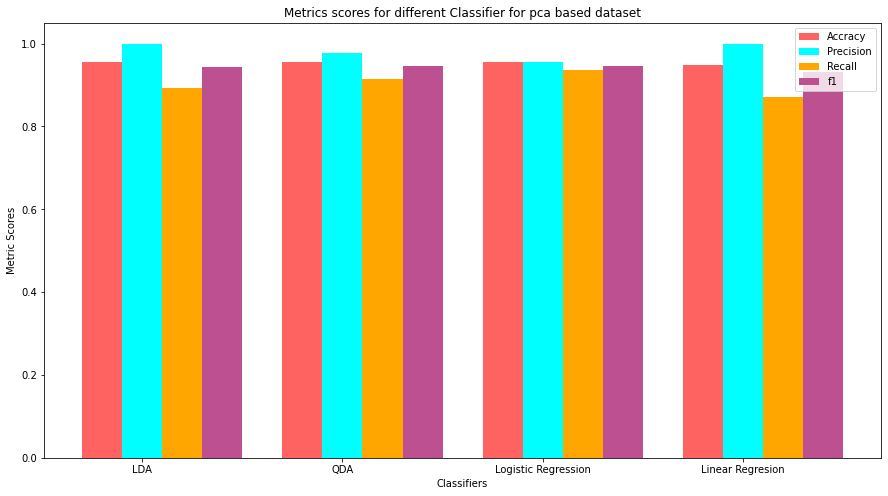

In [91]:
# for dataset-3
def append_metric(ls1,ls2,ls3,ls4,test,pred):
  ls1.append(  accuracy_score(test,pred) )
  ls2.append(  precision_score(test,pred) )
  ls3.append(  recall_score(test,pred) )
  ls4.append(  f1_score(test,pred) )

def write_Val(ps):
  # for i in range(len(x)):
  #   plt.text(x[i], y[i]//2, y[i])
  for p in ps.patches:
    ps.annotate(format(p.get_height(), '.1f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')
  # for index, value in enumerate(y):
    # plt.text(value, index, str(value))
    # plt.text(i, recalls[i]//2, recalls[i], ha = 'center')
    # plt.text(i, precisions[i]//2, precisions[i], ha = 'center')
    # plt.text(i, f1s[i]//2, f1s[i], ha = 'center')

accuracies, precisions, recalls, f1s  = [],[],[],[]

X_train,X_test,y_train,y_test=Xs['set'+str(2)]

ldac=LinearDiscriminantAnalysis(solver='svd')
ldac.fit(X_train,y_train)
y_pred=ldac.predict(X_test)
append_metric( accuracies, precisions, recalls, f1s, y_test, y_pred )


qdac=QuadraticDiscriminantAnalysis()
qdac.fit(X_train,y_train)
y_pred=qdac.predict(X_test) 
append_metric( accuracies, precisions, recalls, f1s, y_test, y_pred )


# best_clf = DecisionTreeClassifier(
#     criterion= best_param_DT['criterion'],
#     max_depth= best_param_DT['max_depth'],
#     min_samples_leaf= best_param_DT['min_samples_leaf'],
#     random_state= best_param_DT['random_state']
#   )
# best_clf.fit(X_train,y_train)
# y_pred = best_clf.predict(X_test)
# append_metric( accuracies, precisions, recalls, f1s, y_test,y_pred )


sgdc=SGDClassifier(loss='log',verbose=False,alpha=grid.best_params_['alpha'],learning_rate=grid.best_params_['learning_rate'],eta0=grid.best_params_['eta0'],random_state=grid.best_params_['random_state'])
sgdc.fit(X_train,y_train)
y_pred=sgdc.predict(X_test)
append_metric( accuracies, precisions, recalls, f1s, y_test, y_pred )

# for regression
accuracies.append(accuracy)
recalls.append(recall)
f1s.append(f1)
precisions.append(precision)

plt.figure(figsize=(15,8))
# fig, ax = plt.subplots()

x = np.arange(1,5)
accx,recx,f1x = x-0.2, x+0.2,x+0.4
width = 0.2

p1 = plt.bar(accx,accuracies,width,color='#ff6361')
p2 = plt.bar(x,precisions,width,color='cyan')
p3 = plt.bar(recx,recalls,width,color='#ffa600')
p4 = plt.bar(f1x,f1s,width,color='#bc5090')

# ax.bar_label(p1,label_type='center')
# write_Val(p1)
# write_Val(p2)
# write_Val(p3)
# write_Val(p4)


plt.title('Metrics scores for different Classifier for pca based dataset')
plt.xticks(x, ['LDA', 'QDA', 'Logistic Regression','Linear Regresion'])
plt.xlabel("Classifiers")
plt.ylabel("Metric Scores")
plt.legend(["Accracy", "Precision", "Recall","f1"])
